# CS 4650 - Natural Language - HW3

Georgia Tech, Fall 2025 (Instructor: Kartik Goyal)

<p style="color: red;">DEADLINE: October 31, 2025, 11:59 PM</p>


This is an assignment on Neural Text Generation. We will be implementing a Encoder-Decoder transformer from scratch, and then use it for Machine Translation from German to English. Through the assignment, we will also explore multiple concepts related to Transformers, such as Multi-Head Attention, Positional Encoding, etc., and decoding techniques like Beam Search, Greedy Sampling, Top-k Sampling, etc.

You can refer to the following resources for PyTorch:
- A good tutorial on PyTorch: [Video](https://www.youtube.com/watch?v=OIenNRt2bjg)
- Detailed Documentation of PyTorch: [Docs](https://pytorch.org/docs/stable/index.html)
- Lecture Material on PyTorch and HuggingFace: [GitHub Repository](https://github.com/neelabhsinha/cs7650-gatech-nlp-pytorch-huggingface-tutorial)

Refer to all the `TODO` comments in the code for the parts you need to implement. The total points for this assignment are 100 points. The assignment is divided into the following sections:

1. Load and Preprocess Data [5 points]
2. Transformer Implementation [35 points]
3. Training [10 points]
4. Decoding/Sampling [30 points]
5. Analysis [20 points]
6. Bonus [15 points]

If images are not visible in the notebook, you can find them in the `images` folder in the assignment directory.

## 0. Setup [0 points - Programming]

In [ ]:
# RUN THESE CODES ONLY IF YOU HAVE ModuleNotFoundError FOR CELL BELOW
import importlib, sys
sys.modules["imp"] = importlib

In [ ]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [ ]:
from importlib import reload

In [ ]:
import torch
import numpy as np

import matplotlib.pyplot as plt

import os

In [ ]:
# assign a torch random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print('Device being used - ', device)

Device being used -  cuda


In [ ]:
# execute only if you are working in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace this by the folder path where you put your assignment. If you are working with local, skip executing the previous cell and add the path to local directory here.
# folder_path = '.'
folder_path = '/content/drive/MyDrive/HW3' # Change the path to the folder where the assignment is stored in Google Drive.

# Files in the folder -
os.listdir(folder_path)

os.chdir(folder_path)

print('Current working directory -', os.getcwd())

Current working directory - /content/drive/MyDrive/HW3


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1. Load and Preprocess Data [5 points - Programming]

In this section, you will create DataLoaders for training your transformer model. You are already provided with functions for reading the parallel corpora and building a vocabulary. (Note that we are building *separate* vocabularies for the source and target languages.)

Your task is to implement the `Batch` class and `collate_batch` function in `datautils.py`.  

In [ ]:
from datautils import collate_batch, Batch, read_pairs, TranslationDataset, build_vocab

In [ ]:
## LOCAL TESTS - DO NOT CHANGE THIS CELL
DATA = os.path.join(os.getcwd(), "data")
# load data
valid_src_path = os.path.join(DATA, "valid.de-en.de")
valid_tgt_path = os.path.join(DATA, "valid.de-en.en")

data = read_pairs(valid_src_path, valid_tgt_path)

# create vocab
src_data = [sent[0] for sent in data]
tgt_data = [sent[1] for sent in data]
src_vocab = build_vocab(src_data, "de")
tgt_vocab = build_vocab(tgt_data, "en")

print("Source vocab size:", len(src_vocab))
print("Target vocab size:", len(tgt_vocab))

# create dataset
dataset = TranslationDataset(data, src_vocab, tgt_vocab)
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503


### 1.1. Batch Class [3 points - Programming]

The `Batch` class is a simple data structure that holds the source and target sequences, along with the target mask and the number of tokens in the batch. The `Batch` class will be used to store the data for each batch during training.

Implement the `Batch` class in `datautils.py`. Most of the implementation is already added by us, you just need to define the correct mask logic. Feel free to do a disjoint section 2.8. before coming back here, as you can use that function here too (you can do this independently as well, it is not a hard constraint).

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL

src = torch.tensor([[ 4699.,  4622., 14840., 10188., 13378.,  7845.,  7015., 11664., 13122.,
          2.,  2., 2.]])
tgt = torch.tensor([[ 15820.,  37673., 29931., 21901., 13016., 43304., 2., 2.]])

batch = Batch(src, tgt)

expected_tgt = torch.Tensor([[1.5820e+04, 3.7673e+04, 2.9931e+04, 2.1901e+04, 1.3016e+04, 4.3304e+04,
         2.0000e+00]])

expected_tgt_y = torch.Tensor([[37673., 29931., 21901., 13016., 43304., 2., 2.]])

expected_tgt_mask = torch.Tensor([[
    [ True, False, False, False, False, False, False],
    [ True,  True, False, False, False, False, False],
    [ True,  True,  True, False, False, False, False],
    [ True,  True,  True,  True, False, False, False],
    [ True,  True,  True,  True,  True, False, False],
    [ True,  True,  True,  True,  True,  True, False],
    [ True,  True,  True,  True,  True,  True,  False]]]).to(torch.bool)

expected_ntokens = 5

assert torch.equal(expected_tgt, batch.tgt), "Test Failed: Incorrect values in response for tgt."
assert torch.equal(expected_tgt_y, batch.tgt_y), "Test Failed: Incorrect values in response for tgt_y."
assert torch.allclose(expected_tgt_mask, batch.tgt_mask), "Test Failed: Incorrect values in response for tgt_mask."
assert expected_ntokens == batch.ntokens.item(), "Test Failed: Incorrect values in response for ntokens."
print("Batch - All tests passed.")

Batch - All tests passed.


### 1.2. Data Collation [2 points - Programming]

The `collate_batch` function is responsible for collating a list of samples into a batch. It pads the sequences to the same length, creates the target mask, and computes the number of tokens in the batch. The function returns a `Batch` object containing the source and target sequences, the target mask, and the number of tokens in the batch.

Implement the `collate_batch` function in `datautils.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
batch = [(
    torch.tensor([4699, 4622, 14840, 10188, 13378, 7845, 7015, 11664, 13122, 2896, 4735, 11933]),
    torch.tensor([3541, 488, 2238, 9053, 1028, 5458, 1735, 11248, 8474])
)]

output = collate_batch(batch, device, 16)

expected_src = torch.Tensor([[    0,  4699,  4622, 14840, 10188, 13378,  7845,  7015, 11664, 13122,
          2896,  4735, 11933,     1,     2,     2]]).to(device).to(torch.long)
expected_tgt = torch.Tensor([[    0,  3541,   488,  2238,  9053,  1028,  5458,  1735, 11248,  8474,
             1,     2,     2,     2,     2]]).to(device).to(torch.long)
expected_tgt_y = torch.Tensor([[ 3541,   488,  2238,  9053,  1028,  5458,  1735, 11248,  8474,     1,
             2,     2,     2,     2,     2]]).to(device).to(torch.long)
expected_tgt_mask = torch.Tensor(

).to(device).to(torch.long)

expected_ntokens = 10

assert torch.equal(expected_src, output.src), "Test Failed: Incorrect values in response for src."
assert torch.equal(expected_tgt, output.tgt), "Test Failed: Incorrect values in response for tgt."
assert torch.equal(expected_tgt_y, output.tgt_y), "Test Failed: Incorrect values in response for tgt_y."
# assert torch.allclose(expected_tgt_mask, output.tgt_mask), "Test Failed: Incorrect values in response for tgt_mask."
assert expected_ntokens == output.ntokens.item(), "Test Failed: Incorrect values in response for ntokens."
print("collate_batch - All tests passed.")

collate_batch - All tests passed.


## 2. Transformer Implementation [35 points - Programming]

Transformers have revolutionized the field of natural language processing (NLP) and beyond, offering remarkable improvements in tasks like machine translation, text summarization, and sentiment analysis. Developed by [Vaswani et al. in their 2017 paper, "Attention is All You Need"](https://arxiv.org/abs/1706.03762) , transformers replace traditional recurrent layers with self-attention mechanisms, enabling the model to process input data in parallel and capture complex dependencies across positions.

This assignment is designed to deepen your understanding of transformers by guiding you through the process of implementing one from scratch. By building a transformer model piece by piece, you will gain insights into the architecture’s inner workings, including the attention mechanism, positional encoding, and the overall encoder-decoder structure.

Most of the code related to this section will be implemented in `model.py`. You will be implementing the following classes and functions.

The code break-up as per the famous diagram of transformer can be visualized as below:
<p align="center">
  <img src="images/transformer_layers.png" alt="Transformer">
</p>

The code implementation will be in `model.py`. The tests for the implementation will be in this notebook.


### 2.1. Positional Encoding [3 points - Programming]

The PositionalEncoding module in PyTorch adds necessary positional dynamics to the input embeddings of transformers. Without these encodings, transformers would not be able to utilize the order of the sequence, as they lack any recurrence or convolutional structures inherent in their design.

This module computes a unique encoding for each position in the sequence up to a specified max_len. The encodings use a combination of sine and cosine functions across different dimensions of the embeddings. Specifically, for each dimension i, the encoding alternates between a sine and cosine function:
- Even indices (0, 2, 4, ...) use sine,
- Odd indices (1, 3, 5, ...) use cosine.

The equations are -
$$ PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) $$
$$ PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) $$

The use of sinusoidal functions helps the model to easily learn to attend by relative positions without much computational overhead. The frequencies of the sine and cosine functions decrease with the dimension, providing a smooth gradient flow for positions that are closer in sequence and differing signals for positions that are further apart.

After computing the positional encodings, they are added directly to the input embeddings. A dropout layer is then applied to the result to reduce overfitting and improve the generalization capabilities of the model during training. The use of dropout is a common regularization technique in neural network training.

Implement the PositionalEncoding class in `model.py`

In [ ]:
from model import PositionalEncoding

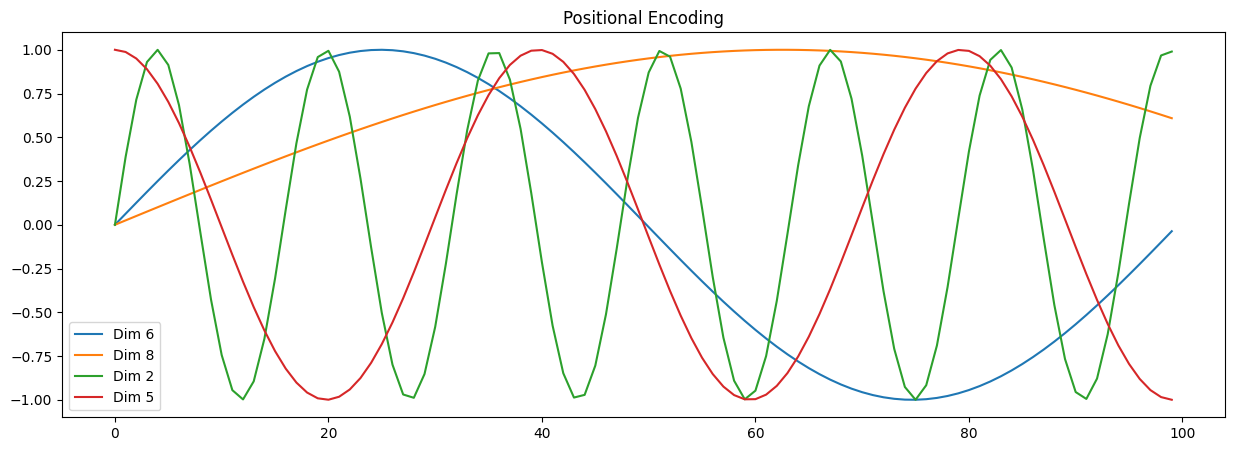

In [ ]:
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))


## Visualize your Positional Encodings (feel free to change to other dimensions)

plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 6].numpy(), label='Dim 6')
plt.plot(np.arange(100), y[0, :, 8].numpy(), label='Dim 8')
plt.plot(np.arange(100), y[0, :, 2].numpy(), label='Dim 2')
plt.plot(np.arange(100), y[0, :, 5].numpy(), label='Dim 5')
plt.legend()
plt.title('Positional Encoding')
plt.show()

In [ ]:
## LOCAL TESTS - DO NOT CHANGE THIS CELL
pe = PositionalEncoding(4, 0)
y = pe.forward(torch.zeros(1, 5, 4))
expected_output = torch.tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [-0.7568, -0.6536,  0.0400,  0.9992]]])
assert y.shape == (1, 5, 4), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(y, expected_output, atol=1e-4), "Test Failed: Incorrect values in response for positional encoding without dropout."

pe = PositionalEncoding(2, 0.1)
x = torch.tensor([[[1, 2], [4, 5]]], dtype=torch.float32)
y = pe.forward(x)
expected_output = torch.tensor([[[1.1111, 3.3333],
         [5.3794, 6.1559]]]
)
assert y.shape == (1, 2, 2), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(y, expected_output, atol=1e-4), "Test Failed: Incorrect values in response for positional encoding with dropout."

print("Positional Encoding - All tests passed.")


Positional Encoding - All tests passed.


### 2.2. Embeddings [3 points - Programming]

The Embeddings provide functionality to transform token indices into dense embeddings. It also scales these embeddings by the square root of the embedding dimension. This scaling is crucial as it helps in maintaining a consistent variance across the embeddings, which is beneficial for stabilizing gradients during training.

This is the same embedding as HW1, with slight change (as you will see in the docstring of the class).

Implement the Embeddings class in `model.py`

In [ ]:
## LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import Embeddings

emb = Embeddings(5, 5)
emb.set_embedding_weights()
x = torch.tensor([[1, 2, 3, 4, 0], [4, 3, 2, 1, 0]])
y = emb(x)
expected_output = torch.tensor([[[0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361]],

        [[0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361],
         [0.0000, 0.5590, 1.1180, 1.6771, 2.2361]]])

assert y.shape == (2, 5, 5), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(y, expected_output, atol=1e-4), "Test Failed: Incorrect values in response for embeddings."
print("Embeddings - All tests passed.")

Embeddings - All tests passed.


### 2.3. Scaled Dot-Product Attention [3 points - Programming]

The attention function is an implementation of the Scaled Dot Product Attention mechanism, which is crucial for models that include transformers. This function calculates attention weights and applies these weights to the values based on the input queries and keys. The attention mechanism allows the model to focus on different parts of the input sequence, enabling it to capture complex dependencies and relationships between tokens.

The Scaled Dot Product Attention function is defined as follows:
$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Here, Q, K, and V are the query, key, and value matrices, respectively. The function first computes the dot product of the query and key matrices, scales the result by the square root of the key dimension, and then applies a softmax function to obtain the attention weights. Finally, the function multiplies the attention weights by the value matrix to produce the output.

<p align="center">
  <img src="images/scaled_dot_product_attention.png" alt="Scaled Dot-product Attention">
</p>



Implement the `attention()` function in `model.py`

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import attention

q = torch.tensor([[[[1, 2, 3], [2, 1, 2], [3, 2, 1]],[[1, 3, 2], [2, 2, 1], [1, 2, 3]]]], dtype=torch.float32)
k = torch.tensor([[[[1, 3, 1], [4, 1, 2], [3, 2, 1]], [[3, 1, 2], [1, 4, 2], [4, 2, 1]]]], dtype=torch.float32)
v = torch.tensor([[[[3, 1, 2], [1, 2, 1], [2, 1, 3]], [[1, 3, 2], [2, 1, 3], [3, 2, 1]]]], dtype=torch.float32)

attended_values, attention_weights = attention(q, k, v)
expected_attended_values_1 = torch.tensor([[[[1.5799, 1.6134, 1.5799],
          [1.1982, 1.8277, 1.3188],
          [1.2806, 1.7427, 1.4914]],
         [[2.0356, 1.0847, 2.8797],
          [2.4735, 1.7788, 1.7477],
          [2.0000, 1.2486, 2.7514]]]])
expected_attention_weights_1 = torch.tensor([[[[0.1933, 0.6134, 0.1933],
          [0.0259, 0.8277, 0.1464],
          [0.0232, 0.7427, 0.2341]],
         [[0.0164, 0.9317, 0.0519],
          [0.1018, 0.3229, 0.5753],
          [0.0829, 0.8343, 0.0829]]]])
assert torch.allclose(attended_values, expected_attended_values_1, atol=1e-4), "Test Failed: Incorrect values in response for Test Case 1 (no dropout, no mask)."
assert torch.allclose(attention_weights, expected_attention_weights_1, atol=1e-4), "Test Failed: Incorrect values in response for Test Case 1 (no dropout, no mask)."
# Evaluate the effect of mask
mask = torch.tensor([[[[1, 1, 1],
                       [1, 1, 0],
                       [1, 0, 0]]]], dtype=torch.float32)
attended_values, attention_weights = attention(q, k, v, mask)
expected_attended_values_2 = torch.tensor([[[[1.5799, 1.6134, 1.5799],
          [1.0607, 1.9696, 1.0304],
          [3.0000, 1.0000, 2.0000]],
         [[2.0356, 1.0847, 2.8797],
          [1.7604, 1.4793, 2.7604],
          [1.0000, 3.0000, 2.0000]]]])
expected_attention_weights_2 = torch.tensor([[[[0.1933, 0.6134, 0.1933],
          [0.0304, 0.9696, 0.0000],
          [1.0000, 0.0000, 0.0000]],
         [[0.0164, 0.9317, 0.0519],
          [0.2396, 0.7604, 0.0000],
          [1.0000, 0.0000, 0.0000]]]])
assert torch.allclose(attended_values, expected_attended_values_2, atol=1e-4), "Test Failed: Incorrect values in response for Test Case 2 (no dropout but mask present)."
assert torch.allclose(attention_weights, expected_attention_weights_2, atol=1e-4), "Test Failed: Incorrect values in response for Test Case 2 (no dropout but mask present)."
# Evaluate the effect of dropout
dropout = torch.nn.Dropout(p=0.3)
attended_values_1, attention_weights_1 = attention(q, k, v, dropout=dropout, mask=mask)
attended_values_2, attention_weights_2 = attention(q, k, v, dropout=dropout, mask=mask)
assert not torch.allclose(attention_weights_1, attention_weights_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
assert not torch.allclose(attended_values_1, attended_values_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("Scaled Dot-Product Attention - All tests passed.")

Scaled Dot-Product Attention - All tests passed.


### 2.4. Multi-Head Attention [3 points - Programming]

The MultiHeadedAttention class encapsulates the multi-head attention mechanism, a pivotal component in transformer architectures. This mechanism allows the model to attend to different parts of the input sequence simultaneously, making it highly effective for tasks involving complex dependencies.

Key Features:

- Parallel Attention Heads: Each head independently computes attention, focusing on different features of the input. The results from each head are then combined to capture a richer representation.
- Dimensionality: The input dimensions are projected into smaller, separate dimensions for each head $(d_k)$, speeding up computation and allowing diverse representations.
- Scalability: By separating the input into multiple heads, the model can scale attention across different subspaces, enhancing learning capabilities and model performance.

<p align="center">
  <img src="images/multihead_attention.png" alt="Multihead Attention">
</p>

In `model.py`, implement the `MultiHeadedAttention` class.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import MultiHeadedAttention
q = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
k = torch.tensor([[[1, 3, 1], [4, 1, 2], [3, 2, 1]], [[3, 1, 2], [1, 4, 2], [4, 2, 1]]], dtype=torch.float32)
v = torch.tensor([[[3, 1, 2], [1, 2, 1], [2, 1, 3]], [[1, 3, 2], [2, 4, 3], [3, 2, 1]]], dtype=torch.float32)
mha = MultiHeadedAttention(3, 3, dropout=0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [1, 3, 2], [2, 4, 1]], [[1, 2, 3], [1, 4, 2], [2, 3, 1]], [[1, 4, 3], [1, 1, 4], [4, 3, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [1, 3, 5], [2, 5, 1], [4, 1, 3]], dtype=torch.float32)
mha.set_weights(weights, biases)
out = mha(q, k, v)
expected_output = torch.tensor([[[115.5003,  76.0002, 114.5010],
         [115.5023,  76.0019, 114.5076],
         [115.5007,  76.0004, 114.5014]],
        [[201.0000, 131.0000, 194.0000],
         [201.0000, 131.0000, 194.0000],
         [201.0000, 131.0000, 194.0000]]])
assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
mha = MultiHeadedAttention(3, 3, dropout=0.5)
out_1 = mha(q, k, v)
out_2 = mha(q, k, v)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("MultiHeadedAttention - All tests passed.")

MultiHeadedAttention - All tests passed.


### 2.5. Feed-Forward Layer [3 points - Programming]

In both the encoder and decoder of our model, each layer includes a fully connected feed-forward network. This network operates independently on each position and follows the same structure throughout. It is composed of two linear transformations. Between these transformations, a ReLU activation function is applied to introduce non-linearity.

$$ \text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2 $$

Implement the `FeedForward` class in `model.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import FeedForward
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
ffn = FeedForward(3, 3, 0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [4, 3, 2], [2, 2, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [2, 2, 3]], dtype=torch.float32)
ffn.set_weights(weights, biases)
out = ffn(x)
expected_output = torch.tensor([[[55., 93., 54.],
         [47., 79., 46.],
         [51., 91., 52.]],
        [[53., 94., 54.],
         [45., 80., 46.],
         [55., 93., 54.]]])
assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
ffn = FeedForward(3, 3, 0.5)
out_1 = ffn(x)
out_2 = ffn(x)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("FeedForward - All tests passed.")

FeedForward - All tests passed.


### 2.6. Layer Normalization [3 points - Programming]

Layer normalization is a technique that normalizes the inputs across the features instead of the batch. It is very effective for stabilizing the learning process in networks that are deep or use complex recurrent structures. The normalization process adjusts the input data in such a way that the mean output per feature vector over a training batch is zero and the standard deviation is one. This is particularly beneficial in models like transformers where the batch size can often vary.

Layer normalization differs from batch normalization as it normalizes across the features for each single sample, and not across the batch dimension. It is extensively used in transformer models.

You can read more about Layer Normalization [here](https://arxiv.org/abs/1607.06450).

Equation -
$$ y = \alpha \odot \frac{x - \mu}{\sigma + \epsilon} + \beta $$

Where:
- x is the input tensor.
- μ is the mean computed over the last dimension.
- σ is the standard deviation computed over the last dimension.
- α is a learnable parameter scaling each feature.
- β is a learnable parameter shifting each feature.
- ϵ is a small constant (epsilon) added for numerical stability.

Implement the `LayerNorm` class in `model.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import LayerNorm

x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
ln = LayerNorm(3)
out = ln(x)
expected_output = torch.tensor([[[-1.0000,  0.0000,  1.0000],
         [ 0.5773, -1.1547,  0.5773],
         [ 1.0000,  0.0000, -1.0000]],
        [[-1.0000,  1.0000,  0.0000],
         [ 0.5773,  0.5773, -1.1547],
         [-1.0000,  0.0000,  1.0000]]])
assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results."
print("LayerNorm - All tests passed.")


LayerNorm - All tests passed.


### 2.7. Residual Stream Block [3 points - Programming]

The Residual Stream Block is designed to encapsulate two primary functionalities essential in modern neural network architectures: normalization and residual connections. This combination is particularly popular in transformer models and helps combat the vanishing gradient problem in deep networks.

- Layer Normalization: This step normalizes the input tensor's features to have zero mean and unit variance, which stabilizes learning by making the model less sensitive to different input scales.
- Residual Connection: The residual connection allows gradients to flow through the network directly by adding the input tensor x to the output of a transformation applied to x. This skip-connection technique is critical for training deeper networks efficiently.
- Dropout: Integrated into the pathway, dropout is a regularization technique that "drops out" random neuron outputs during training to prevent overfitting and encourage robust internal representations.

Implement the `ResidualStreamBlock` class in `model.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import ResidualStreamBlock
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
linear = torch.nn.Linear(3, 3, bias=False)
linear.weight.data = torch.tensor([[1, 2, 1], [1, 1, 2], [2, 1, 1]], dtype=torch.float32)
scl = ResidualStreamBlock(3, 0.0)
out = scl(x, linear)
expected_output = torch.tensor([[[1.0000, 3.0000, 2.0000],
         [0.8453, 1.5773, 2.5773],
         [3.0000, 1.0000, 2.0000]],
        [[2.0000, 3.0000, 1.0000],
         [2.5773, 0.8453, 1.5773],
         [1.0000, 3.0000, 2.0000]]])
assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
scl = ResidualStreamBlock(3, 0.5)
out_1 = scl(x, linear)
out_2 = scl(x, linear)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("ResidualStreamBlock - All tests passed.")


ResidualStreamBlock - All tests passed.


### 2.8. Autoregressive Masking [3 points - Programming]

An autoregressive mask generates a boolean mask used to control the flow of information in the sequence. This mask that output at a certain position in a sequence is only dependent on the previous positions and not any future positions. This mechanism is crucial in tasks like sequence generation where the model should not have access to future input during training.

Implement the `autoregressive_mask` function in `model.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import autoregressive_mask
mask = autoregressive_mask(3)
expected_output = torch.tensor([[[1, 0, 0],
         [1, 1, 0],
         [1, 1, 1]]], dtype=torch.bool)
assert mask.shape == (1, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(mask, expected_output, atol=1e-4), "Test Failed: Incorrect results."
mask = autoregressive_mask(7)
expected_output = torch.tensor([[[1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1]]], dtype=torch.bool)
assert mask.shape == (1, 7, 7), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(mask, expected_output, atol=1e-4), "Test Failed: Incorrect results."
print("Subsequent Mask - All tests passed.")

Subsequent Mask - All tests passed.


These are the basic building blocks of the Transformer model. In the next sections, we will implement the Encoder and Decoder classes, and then combine them to create the full Transformer model.
Note, the encoder-decoder transformer is the fundamental form of transformer with self-attention and cross-attention. It is widely used in machine translation tasks, or summarization tasks.

Apart from there, there are also encoder-only transformers, and decoder-only transformers. The encoder-only transformers are used in tasks like language modeling, where the model is trained to predict the next word in a sequence. The decoder-only transformers are used in tasks like text generation, where the model is trained to generate a sequence of words given an input sequence.

BERT is an example of an encoder-only transformer, while GPT is an example of a decoder-only transformer. In this assignment, we will be implementing the encoder-decoder transformer. Some encoder-decoder transformers are BART, T5, etc.

Let's move to utilizing the building blocks we have implemented so far to create the Encoder and Decoder classes, and then combine them to create the full Transformer model.

### 2.9. Transformer Encoder Block [3 points - Programming]

It is designed to encapsulate two main submodules: self-attention and a feed-forward network.

- Self-attention Module: This module allows each position in the encoder to attend to all positions in the previous layer of the encoder, which captures intricate dependencies in the input data regardless of their distance in the input sequence. This is an instance of multi-head attention, where the query, key, and value inputs are all derived from the same input.
- Feed-forward Network: Each position is separately and identically processed by the feed-forward network, which typically consists of two linear transformations with a ReLU activation in between. This is the same feed-forward network we implemented earlier.
- Sublayer Connections: Each of these components is embedded in a ResidualStreamBlock, which applies a residual connection followed by layer normalization. This design promotes direct pathways for gradients during training, facilitating the training of deep networks. This is the same sublayer connection we implemented earlier.

Process Flow in forward Method:
- The input tensor x is first passed through the self-attention mechanism within a sublayer connection, which also uses a mask to ignore certain positions (useful for handling padded positions in sequences).
- The output of the self-attention is then passed through the feed-forward network within another sublayer connection.
- This structure effectively allows the encoder to enhance its representation capabilities with depth, leveraging both self-attention and dense layers, while maintaining stability through normalization and residual connections.

Implement the `EncoderBlock` class in `model.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import EncoderBlock
from model import MultiHeadedAttention, FeedForward
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
mha = MultiHeadedAttention(3, 3, dropout=0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [1, 3, 2], [2, 4, 1]], [[1, 2, 3], [1, 4, 2], [2, 3, 1]], [[1, 4, 3], [1, 1, 4], [4, 3, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [1, 3, 5], [2, 5, 1], [4, 1, 3]], dtype=torch.float32)
mha.set_weights(weights, biases)
ffn = FeedForward(3, 3, 0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [4, 3, 2], [2, 2, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [2, 2, 3]], dtype=torch.float32)
ffn.set_weights(weights, biases)
eb = EncoderBlock(3, mha, ffn, 0.0)
mask = None
out = eb(x, mask)
expected_output = torch.tensor([[[50.9330, 37.6713, 46.5334],
         [51.7019, 36.5467, 45.3967],
         [50.7294, 36.9257, 42.9702]],

        [[59.8909, 43.0178, 53.5605],
         [58.5936, 41.4671, 50.4271],
         [60.3661, 41.9595, 54.0644]]])

assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
eb = EncoderBlock(3, mha, ffn, 0.5)
out_1 = eb(x, mask)
out_2 = eb(x, mask)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("EncoderBlock - All tests passed.")

EncoderBlock - All tests passed.


### 2.10. Transformer Encoder

The encoder consists of a stack of identical layers, each of which may involve operations such as self-attention and feed-forward transformations. Each layer is expected to maintain a consistent interface and dimensionality, specified by the size attribute. After data passes through all the layers, a final layer normalization is applied. This step is crucial as it ensures that the outputs of the encoder are normalized, reducing the risk of instability in gradients and aiding in faster convergence.

The forward method illustrates the sequential processing of the input $x$ through each layer in the stack, with an optional mask applied at each step. The mask is typically used to nullify the effects of padding in sequence data, ensuring that padding does not influence the learning process. By allowing the encoder to stack an arbitrary number of identical layers, this design supports scalability and depth in model architecture, enabling it to learn more complex features and relationships in data.

This implementation is streamlined yet flexible, accommodating any layer structure that fits the defined interface, making it a versatile component in advanced neural network architectures.

Implement the `Encoder` class in `model.py`.
There are no local tests for this cell due to large complexity in initializations. The implementation only requires stacking the EncoderBlock, and reusing existing classes.

In [ ]:
# EXECUTION CHECK
from model import Encoder, EncoderBlock, MultiHeadedAttention, FeedForward
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
encoder_block = EncoderBlock(3, MultiHeadedAttention(3, 3, dropout=0.0), FeedForward(3, 3, 0.0), 0.0)
encoder = Encoder(encoder_block, 2)

print(encoder)

# Try to map this to the transformers architecture diagram and understand if you have got the entire encoder.


Encoder(
  (layers): ModuleList(
    (0-1): 2 x EncoderBlock(
      (self_attn): MultiHeadedAttention(
        (linears): ModuleList(
          (0-3): 4 x Linear(in_features=3, out_features=3, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (w_1): Linear(in_features=3, out_features=3, bias=True)
        (w_2): Linear(in_features=3, out_features=3, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_block1): ResidualStreamBlock(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_block2): ResidualStreamBlock(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm()
)


### 2.11. Transformer Decoder Block [3 points - Programming]

The Decoder block in transformer models is designed to process the output from the encoder and generate a sequence output in tasks like translation or text generation. Each decoder layer contains three key sub-modules:
- a self-attention mechanism, which helps the decoder focus on relevant parts of the input sequence
- a cross-attention mechanism, allowing the decoder to attend to the entire output of the encoder
- a position-wise feed-forward network, which applies a set of fully connected layers to each position independently.

These sub-modules are encapsulated within a framework that includes residual connections and layer normalization, crucial for stabilizing the learning process and enabling deeper model architectures. Understanding these components is essential for students delving into how transformers maintain context and generate coherent outputs in sequence-to-sequence tasks.

Implement the `DecoderBlock` class in `model.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import DecoderBlock, MultiHeadedAttention, FeedForward, ResidualStreamBlock, autoregressive_mask
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
mha_self = MultiHeadedAttention(3, 3, dropout=0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [1, 3, 2], [2, 4, 1]], [[1, 2, 3], [1, 4, 2], [2, 3, 1]], [[1, 4, 3], [1, 1, 4], [4, 3, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [1, 3, 5], [2, 5, 1], [4, 1, 3]], dtype=torch.float32)
mha_self.set_weights(weights, biases)
mha_cross = MultiHeadedAttention(3, 3, dropout=0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 9, 1]], [[1, 3, 1], [4, 3, 2], [2, 2, 1]], [[5, 2, 1], [1, 3, 2], [2, 1, 1]], [[1, 3, 0], [4, 3, 2], [2, 2, 6]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 2], [1, 3, 7], [2, 5, 4], [4, 9, 3]], dtype=torch.float32)
mha_cross.set_weights(weights, biases)
ffn = FeedForward(3, 3, 0.0)
weights = torch.tensor([[[1, 2, 1], [1, 1, 2], [2, 1, 1]], [[1, 3, 1], [4, 3, 2], [2, 2, 1]]], dtype=torch.float32)
biases = torch.tensor([[1, 2, 4], [2, 2, 3]], dtype=torch.float32)
ffn.set_weights(weights, biases)
db = DecoderBlock(3, mha_self, mha_cross, ffn, 0.0)
src_mask = None
tgt_mask = autoregressive_mask(3)
memory = torch.tensor([[[1, 1, 0], [2, 3, 1], [1, 2, 1]], [[1, 1, 1], [3, 2, 1], [1, 2, 4]]], dtype=torch.float32)
out = db(x, memory, src_mask, tgt_mask)

expected_output = torch.tensor([[[117.3262, 158.9924, 158.8624],
         [116.6737, 155.3791, 152.4066],
         [121.2165, 166.5353, 150.3511]],
        [[126.4522, 174.3401, 168.4910],
         [127.5165, 177.1474, 165.8177],
         [127.0625, 175.4266, 167.4181]]])

assert out.shape == (2, 3, 3), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results without dropout."
db = DecoderBlock(3, mha_self, mha_cross, ffn, 0.5)
out_1 = db(x, memory, src_mask, tgt_mask)
out_2 = db(x, memory, src_mask, tgt_mask)
assert not torch.allclose(out_1, out_2, atol=1e-4), "Test Failed: Incorrect results with dropout."
print("DecoderBlock - All tests passed.")

DecoderBlock - All tests passed.


### 2.12. Transformer Decoder

The decoder consists of a stack of identical decoder blocks. Each layer is expected to maintain a consistent interface and dimensionality, specified by the size attribute. After data passes through all the layers, a final layer normalization is applied.

Decoder is constructed with DecoderBlock just the same way as Encoder is constructed with EncoderBlock.

Implement the `Decoder` class in `model.py`.

There are no local tests for this cell due to large complexity in initializations. The implementation only requires stacking the `DecoderBlock`, and reusing existing classes.

In [ ]:
# EXECUTION CHECK
from model import Decoder, DecoderBlock, MultiHeadedAttention, FeedForward, ResidualStreamBlock, autoregressive_mask
x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)
decoder_block = DecoderBlock(3, MultiHeadedAttention(3, 3, dropout=0.0), MultiHeadedAttention(3, 3, dropout=0.0), FeedForward(3, 3, 0.0), 0.0)
decoder = Decoder(decoder_block, 2)

print(decoder)

Decoder(
  (layers): ModuleList(
    (0-1): 2 x DecoderBlock(
      (self_attn): MultiHeadedAttention(
        (linears): ModuleList(
          (0-3): 4 x Linear(in_features=3, out_features=3, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (cross_attn): MultiHeadedAttention(
        (linears): ModuleList(
          (0-3): 4 x Linear(in_features=3, out_features=3, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (w_1): Linear(in_features=3, out_features=3, bias=True)
        (w_2): Linear(in_features=3, out_features=3, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_block1): ResidualStreamBlock(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_block2): ResidualStreamBlock(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (residual_stream_

### 2.13. Generator [3 points - Programming]

The Generator class serves as the final component of the decoder output pipeline, transforming high-dimensional decoder outputs into a probability distribution over a predefined vocabulary. It achieves this by employing a linear transformation that maps the decoder's feature space to the vocabulary space, followed by a log softmax function. The log softmax ensures the output values are log probabilities, which are more numerically stable for the computation of loss functions like cross-entropy during training. Understanding the mechanics of the Generator is crucial for those looking to delve into the specifics of neural output generation, particularly how models like Transformers predict the next sequence of tokens in a given task.

Implement the `Generator` class in `model.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
import model
reload(model)

from model import Generator

generator = Generator(3, 10)
weight = torch.tensor([[1, 2, 1], [1, 1, 2], [2, 1, 1], [1, 3, 1], [1, 3, 2], [2, 4, 1], [5, 2, 1], [1, 3, 2], [2, 1, 1], [1, 3, 0]], dtype=torch.float32)
bias = torch.tensor([1, 2, 4, 2, 2, 3, 2, 5, 4, 9], dtype=torch.float32)

x = torch.tensor([[[1, 2, 3], [2, 1, 2], [3, 2, 1]], [[1, 3, 2], [2, 2, 1], [1, 2, 3]]], dtype=torch.float32)

generator.set_weights(weight, bias)
out = generator(x)
expected_output = torch.tensor([[[ -9.2957,  -7.2957,  -7.2957,  -6.2957,  -3.2957,  -2.2957,  -4.2957,
           -0.2957,  -7.2957,  -2.2957],
         [ -9.2946,  -7.2946,  -5.2946,  -7.2946,  -5.2946,  -3.2946,  -0.2946,
           -2.2946,  -5.2946,  -2.2946],
         [-13.0388, -13.0388,  -9.0388, -10.0388,  -9.0388,  -4.0388,  -0.0388,
           -6.0388,  -9.0388,  -4.0388]],
        [[-10.1236, -10.1236,  -9.1236,  -6.1236,  -4.1236,  -1.1236,  -5.1236,
           -1.1236,  -9.1236,  -1.1236],
         [ -9.9233,  -9.9233,  -6.9233,  -6.9233,  -5.9233,  -1.9233,  -0.9233,
           -2.9233,  -6.9233,  -0.9233],
         [ -9.2957,  -7.2957,  -7.2957,  -6.2957,  -3.2957,  -2.2957,  -4.2957,
           -0.2957,  -7.2957,  -2.2957]]])

assert out.shape == (2, 3, 10), "Test Failed: Incorrect shape of obtained response."
assert torch.allclose(out, expected_output, atol=1e-4), "Test Failed: Incorrect results."
print("Generator - All tests passed.")

Generator - All tests passed.


### 2.14. The Complete Transformer

Great, we have now implemented all components of the Transformer model. Before we move ahead, feel free to map your implementations to the diagram of the transformer. It will make a lot of things clear going forward.

Let's now combine these components to create the full Transformer model. The Transformer model consists of an encoder, a decoder, and a generator. The encoder processes the input sequence, the decoder generates the output sequence, and the generator converts the decoder output into a probability distribution over the vocabulary.

Implement the `Transformer` class in `model.py`.

Like the Encoder and Decoder, this also won't have local tests due to the complexity in initializations.

After this, to complete the model definition, thoroughly go through the `make_model()` function in `model.py`. This function will create an instance of the Transformer model with the specified hyperparameters.

### 2.15. Inference Test on Untrained Transformer [2 points - Programming]

Let's run a dummy inference on an untrained transformer to check if things are fine.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from model import make_model
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, autoregressive_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()

def show_example(fn, args=[]):
        return fn(*args)

show_example(run_tests)

Example Untrained Model Prediction: tensor([[ 0,  5, 10, 10, 10, 10, 10, 10, 10,  6]])
Example Untrained Model Prediction: tensor([[0, 2, 0, 2, 0, 2, 0, 2, 0, 2]])
Example Untrained Model Prediction: tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 5]])
Example Untrained Model Prediction: tensor([[0, 5, 6, 2, 5, 6, 9, 6, 9, 6]])
Example Untrained Model Prediction: tensor([[ 0,  8, 10, 10, 10,  9,  8, 10,  4,  7]])
Example Untrained Model Prediction: tensor([[ 0, 10,  2,  2,  2,  2,  2,  2, 10, 10]])
Example Untrained Model Prediction: tensor([[0, 7, 8, 2, 6, 5, 2, 6, 5, 2]])
Example Untrained Model Prediction: tensor([[0, 1, 4, 1, 4, 1, 4, 1, 4, 1]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[ 0,  9,  5,  1, 10,  1,  1,  1,  1, 10]])


---

## 3. Model Training [5 points - Programming + 5 points - Non-programming]

In this section, we will implement the training loop for the Transformer model. We will also implement the label smoothing technique to regularize the model during training.
We have already provided most of the training utils that we asked you to implement during previous homeworks. You can find them in `utils.py`, `model_training.py` and `datautils.py`. Some of the implementations will be done by you in this section.

### 3.1 Label Smoothing [5 points - Programming]

The label smoothing loss (introduced in [Szegedy 2015](https://arxiv.org/pdf/1512.00567)) is a regularization technique used to prevent the model from overfitting to the training data. The label smoothing loss is implemented in the `LabelSmoothing` class in the `utils.py` file.

Let's say the model has a vocabulary $V$ so that the model outputs a $|V|$-dimensional vector each token. If `target` is the true label of the next token prediction task, then the *true distribution* is given by the $|V|$-dimensional vector $t$ where the `target` index is set to 1 and all other indices are set to 0.

Since we want the model to be less confident, we would like to *smooth* this label by uniformly spreading the probability mass from the `target` index to all other indices. (In our implementation, we exclude the padding index from the smoothed distribution because we never want to predict the padding token.) Thus, the smoothed distribution vector $s$ is given by:



$$
s[\mathrm{target}] = 1 - \epsilon
$$

$$
s[\mathrm{pad\_id}] = 0
$$

and

$$
s[i] = \frac{\epsilon}{|V|-1}      
$$

for all $i \neq \mathrm{target}, \mathrm{pad\_id}$.


(For training, we will be feeding the LabelSmoothing loss through the `LossWrapper` class for convenience.)

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from utils import LabelSmoothing
import torch

PAD_ID = 3
VOCAB_SIZE = 10

label_smoothing = LabelSmoothing(
    vocab_size=VOCAB_SIZE,
    padding_idx=PAD_ID,
    smoothing=0.2
)
out = torch.ones(8,VOCAB_SIZE).to(torch.float32)
target = torch.ones(8).contiguous().view(-1).to(torch.int64)

loss_val = label_smoothing(out, target).detach()
expected_loss = torch.tensor(-14.6642)
assert torch.isclose(loss_val, expected_loss, atol=1e-4), f"Test Failed: Incorrect results: {loss_val}"
print("Label Smoothing - All tests passed.")

Label Smoothing - All tests passed.


### 3.2 Training Loop [5 points - Non-Programming]

Since we have all the components ready, let's now implement the training loop.

`REQUIREMENT`: To achieve full credits, submit the output of the two cells of Section 3.2.2., along with the training trace of last 3 epochs. It should show the losses, and hyperparameters.

#### 3.2.1. Gradient Accumulation

Gradient accumulation is a trick for training large models when you have limited GPU memory. Rather than updating the model weights after every batch (as in standard minibatch stochastic gradient descent), we only update the weights after passing through multiple batches. This means the gradients are *accumulated*, i.e. summed up over multiple batches.  We can thus simulate training with a large batch size while still using a GPU with a limited memory.

Implement the `run_epoch()` function in `model_training.py`. (All the other functions are provided for you). We have implemented the training forward pass, you just need to implement the backward pass. We do not have local tests for this, so please follow the hints carefully. Gradient accumulation is important, please implement that correctly, else you may find your model hard to train.



#### 3.2.2. Model Training

Run the following cell to train the model (or load a previously saved checkpoint). Note that training can take several hours.

Go to `model_training.py` and adjust your hyperparameters in `ModelHyperParams` and `TrainingHyperParams`. We have already provided an initial set to give you an acceptable starting point, but feel free to make any changes.

If your model fails, you can resume training from the last checkpoint by setting the `continue_training` parameter in the `TrainingHyperParams` dataclass to the path. Pass the path to the checkpoint to the `continue_training` parameter in the `TrainingHyperParams` dataclass. Make it `None` if you want to start training from scratch.

Note, for getting acceptable results in the next section, it is recommended that your validation loss is less than 0.0002. However, this is not a strict requirement for this assignment. You may not achieve this and still succeed, or you may achieve this and still fail. The main goal is to implement the model correctly and understand the concepts.

Some statistics: It took us 12 min/epoch and 20 GB GPU RAM on an Nvidia A100 GPU (on Google Colab) with the given hyperparameters in the `model_training.py` file. The saved weights were around 590 MB per epoch. You can expect it to take much longer on a less powerful GPU. Please plan your resources accordingly. Note, the default GPU on Colab is Tesla T4.

Feel free to stop the training anytime you think your model is trained enough.


In [ ]:
# DO NOT CHANGE THIS CELL
from model_training import load_trained_model, ModelHyperParams, TrainingHyperParams
training_hp = TrainingHyperParams()
model_hp = ModelHyperParams()
print('Training Hyperparameters:', training_hp)
print('---------------------------------------------------------------------------')
print('Model Hyperparameters:', model_hp)

Training Hyperparameters: TrainingHyperParams(train_src_path='/content/drive/MyDrive/HW3/data/train.de-en.de', train_tgt_path='/content/drive/MyDrive/HW3/data/train.de-en.en', valid_src_path='/content/drive/MyDrive/HW3/data/valid.de-en.de', valid_tgt_path='/content/drive/MyDrive/HW3/data/valid.de-en.en', batch_size=64, lr=0.0001, num_epochs=18, accum_iter=10, max_padding=128, warmup=4000, save_every=1, continue_training=None)
---------------------------------------------------------------------------
Model Hyperparameters: ModelHyperParams(n_blocks=6, d_model=512, d_ff=2048, num_heads=8, dropout=0.1)


In [ ]:
# DO NOT CHANGE THIS CELL
# TODO: train the model
if device == 'cuda':
  torch.cuda.empty_cache()
model_path = "./model_weights/model_epoch_final.pt"
model = load_trained_model(training_hp, model_hp, model_path=model_path,
                           src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))

Expected model path: ./model_weights/model_epoch_final.pt
No checkpoint found. Training model...
Using device: cuda
Initializing training...
Loading de tokens from local file...
Loading en tokens from local file...
Number of training batches: 2396
Number of validation batches: 109
Initialized dataloaders. Training source vocab: 16181, target vocab: 11503
Initializing new model...
Training model...
Epoch 0 Training ====


/content/drive/MyDrive/HW3/model_training.py:206: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print("Batch Step: %6d | Accumulation Step: %3d | Loss: %6.2f" % (


Batch Step:      1 | Accumulation Step:   0 | Loss:   8.15
Batch Step:    129 | Accumulation Step:  13 | Loss:   6.94
Batch Step:    257 | Accumulation Step:  25 | Loss:   6.22
Batch Step:    385 | Accumulation Step:  38 | Loss:   5.56
Batch Step:    513 | Accumulation Step:  51 | Loss:   5.14
Batch Step:    641 | Accumulation Step:  64 | Loss:   4.91
Batch Step:    769 | Accumulation Step:  77 | Loss:   4.62
Batch Step:    897 | Accumulation Step:  89 | Loss:   4.71
Batch Step:   1025 | Accumulation Step: 102 | Loss:   4.66
Batch Step:   1153 | Accumulation Step: 115 | Loss:   4.59
Batch Step:   1281 | Accumulation Step: 128 | Loss:   4.48
Batch Step:   1409 | Accumulation Step: 141 | Loss:   4.26
Batch Step:   1537 | Accumulation Step: 153 | Loss:   4.25
Batch Step:   1665 | Accumulation Step: 166 | Loss:   4.20
Batch Step:   1793 | Accumulation Step: 179 | Loss:   4.13
Batch Step:   1921 | Accumulation Step: 192 | Loss:   4.14
Batch Step:   2049 | Accumulation Step: 205 | Loss:   4.

## 4. Decoding/Sampling [30 points - Programming]

In the previous section, we implemented and trained the Transformer model. Now, we will implement the decoding/sampling mechanism to generate the output sequence given the input sequence using the trained model.

The sampling process involves generating the output sequence token by token. At each step, the model predicts the next token in the sequence based on the input sequence and the tokens generated so far. The predicted token is then appended to the output sequence, and the process is repeated until an end-of-sequence token is generated or the maximum sequence length is reached. This technique is transferable across various sequence-to-sequence tasks, including machine translation, text summarization, open-ended generation, question-answering, etc. Different strategies navigate this balance in unique ways, impacting the model's output in terms of variability, unpredictability, and fidelity to human-like language patterns.

Here is a great reference blog on Sampling Techniques - https://huggingface.co/blog/how-to-generate

In this assignment, we will implement 5 decoding strategies, the implementation of which will be done in `sequence_generator.py` file. They are as follows -
- Greedy Decoding
- Random Sampling
- Top-k Sampling
- Top-p Sampling
- Beam Search

First we will implement the logic of each of the strategy given a probability distribution, and then move to utilizing those functions to decode the output sequence using the trained Transformer model.

### 4.1. Greedy Decoding [2 points - Programming]

Greedy decoding is a simple decoding strategy where the token with the highest probability is selected at each step. This strategy is computationally efficient but may lead to suboptimal results as it does not consider the uncertainty in the model's predictions.

Implement the `sample_greedy` function in `sequence_generator.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator

probs = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.33, 0.32, 0.2, 0.15]], dtype=torch.float32) # sum of each row is 1
token_ids, log_probs = SequenceGenerator.sample_greedy(probs)
expected_token_ids = torch.tensor([3, 0], dtype=torch.long)
expected_log_probs = torch.tensor([-0.9163, -1.1087], dtype=torch.float32)
assert torch.allclose(token_ids, expected_token_ids), "Test Failed: Incorrect token_ids."
assert torch.allclose(log_probs, expected_log_probs, atol=1e-4), "Test Failed: Incorrect log_probs."
print("Greedy Sampling - All tests passed.")

Greedy Sampling - All tests passed.


### 4.2. Random Sampling [3 points - Programming]

Random sampling, selects the next word purely based on its predicted probability, allowing for a high degree of diversity but at the risk of producing less coherent sentences. It involves selecting the next word in a sequence based on a probability distribution over the vocabulary. This distribution is derived from the model's predictions, indicating how likely each word is to follow the given context. Here's a mathematical breakdown of how random sampling works:

Given a sequence of words $S = \{s_1, s_2, \ldots, s_{n-1}\}$, an NLP model predicts the next word $s_n$ by estimating the probability distribution $P(V|S)$ over the vocabulary $V = \{v_1, v_2, \ldots, v_M\}$, where $M$ is the size of the vocabulary. The model outputs a probability $P(v_i|S)$ for each word $v_i$ in the vocabulary, indicating the likelihood of $v_i$ being the next word. These probabilities are normalized so that they sum up to 1:

$$\sum_{i=1}^{M} P(v_i|S) = 1$$

Random Sampling involves selecting the next word $s_n$ from the vocabulary $V$ based on the predicted probabilities. Specifically, each word $v_i$ is chosen with a probability $P(v_i|S)$. This selection process can be conceptualized as a random variable $X$ with a multinomial distribution, where the probability mass function (PMF) for $X = v_i$ (the event of choosing word $v_i$ as the next word) is given by:

$$P(X = v_i) = P(v_i|S)$$

This process is repeated for each new word in the sequence, with the context $S$ being updated to include the newly chosen words, until a termination condition is met (e.g., a maximum sequence length or the selection of a special end-of-sequence token).

Implement the `sample_random` function in `sequence_generator.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator
from torch.nn.functional import softmax

logit = torch.tensor([[10, -10, -10, -5], [10, 50, 11, 5]], dtype=torch.float32)
even_logit = torch.tensor([[10, 10, 10, 10], [100, 100, 10, 10]], dtype=torch.float32)
probs = softmax(logit, dim=-1)
even_probs = softmax(even_logit, dim=-1)
token_ids, log_probs = SequenceGenerator.sample_random(probs)
expected_token_ids = torch.tensor([0, 1], dtype=torch.long)
expected_log_probs = torch.tensor([-3.5763e-07,  0.0000e+00], dtype=torch.float32)
assert torch.allclose(token_ids, expected_token_ids), "Test Failed: Incorrect token_ids for Test 1."
assert torch.allclose(log_probs, expected_log_probs, atol=1e-9), "Test Failed: Incorrect log_probs for Test 1."

token_ids, log_probs = SequenceGenerator.sample_random(even_probs)
expected_log_probs = torch.tensor([-1.3863, -0.6931], dtype=torch.float32)
assert torch.allclose(log_probs, expected_log_probs, atol=1e-4), "Test Failed: Incorrect log_probs for Test 2."
print("Random Sampling - All tests passed.")


Random Sampling - All tests passed.


### 4.3. Top-k Sampling [3 points - Programming]

Top-k sampling is a decoding strategy that involves selecting the next word from the top k most likely words in the probability distribution. This technique balances the diversity of random sampling with the stability of greedy sampling by restricting the selection to a subset of the vocabulary. The top-k sampling strategy is particularly useful in scenarios where the model's predictions are uncertain, as it allows for a controlled exploration of the vocabulary space.

Given a context sequence $S = \{s_1, s_2, \ldots, s_{n-1}\}$, and a vocabulary $V = \{v_1, v_2, \ldots, v_M\}$, the model computes a probability distribution $P(V|S)$, predicting the likelihood of each word in the vocabulary being the next appropriate word.

In top-k sampling, the model first identifies the subset $V_k \subseteq V$ consisting of the top $k$ words with the highest probabilities. Mathematically, this subset is defined as:

$$
V_k = \{v | P(v|S) \text{ is among the top } k \text{ of all } P(v_i|S), \forall v_i \in V\}
$$

The probability distribution is then modified to focus solely on these $k$ words, with probabilities outside this set being set to zero. The modified distribution $P'(V|S)$ is defined as:

$$
P'(v_i|S) =
\begin{cases}
P(v_i|S) & \text{if } v_i \in V_k \\
0 & \text{otherwise}
\end{cases}
$$

The probabilities in $P'(V|S)$ are then renormalized so that they sum to 1, ensuring a valid probability distribution. The next word is sampled from this adjusted distribution, effectively narrowing the selection to the most probable candidates and discarding less likely, potentially noisy options.

The selection of the next word $s_n$ is, therefore, a random variable $X$ with a distribution reflecting the adjusted probabilities:

$$
P(X = v_i) = \frac{P'(v_i|S)}{\sum_{v_j \in V_k} P'(v_j|S)}
$$

Top-k sampling balances the diversity of text generation with the coherence of the generated sequences, making it a preferred choice in scenarios where quality and readability of the generated text are crucial.

You can refer [this paper](https://arxiv.org/pdf/1805.04833.pdf) for more on Top-k Sampling.


Implement the `sample_top_k` function in `sequence_generator.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator
from torch.nn.functional import softmax

logit = torch.tensor([[10, -10, -10, -5], [10, 50, 11, 5]], dtype=torch.float32)
even_logit = torch.tensor([[10, 10, 10, 10], [100, 100, 10, 10]], dtype=torch.float32)
probs = softmax(logit, dim=-1)
even_probs = softmax(even_logit, dim=-1)
token_ids, log_probs = SequenceGenerator.sample_top_k(probs, k=3)
expected_token_ids = torch.tensor([0, 1], dtype=torch.long)
expected_log_probs = torch.tensor([-2.9802e-07,  0.0000e+00], dtype=torch.float32)
assert torch.allclose(token_ids, expected_token_ids), "Test Failed: Incorrect token_ids for Test 1."
assert torch.allclose(log_probs, expected_log_probs, atol=1e-9), "Test Failed: Incorrect log_probs for Test 1."

token_ids, log_probs = SequenceGenerator.sample_top_k(even_probs, k=3)
expected_log_probs = torch.tensor([[-1.0986, -0.6931]], dtype=torch.float32)
assert torch.allclose(log_probs, expected_log_probs, atol=1e-4), "Test Failed: Incorrect log_probs for Test 2."

print("Top-k Sampling - All tests passed.")

Top-k Sampling - All tests passed.


### 4.4. Top-p Sampling [3 points - Programming]

Top-p sampling, also known as nucleus sampling, is a decoding strategy that involves selecting the next word from the smallest set of words whose cumulative probability mass exceeds a predefined threshold p.

It is an adaptive technique that balances the trade-off between randomness and determinism. Unlike top-k sampling that selects the top $k$ most probable words, top-p sampling dynamically selects a subset of the vocabulary by choosing the smallest set of words whose cumulative probability exceeds a threshold $p$. This method focuses on the "nucleus" of probable words, discarding the tail of less likely words to ensure both diversity and coherence in the generated text.

Given a sequence $S = \{s_1, s_2, \ldots, s_{n-1}\}$ and a vocabulary $V = \{v_1, v_2, \ldots, v_M\}$, the model first computes the probability distribution $P(V|S)$ for the next word. The words in $V$ are then sorted by their probability in descending order, resulting in a sorted list $V_{sorted} = \{v_{(1)}, v_{(2)}, \ldots, v_{(M)}\}$ where $P(v_{(1)}|S) \ge P(v_{(2)}|S) \ge \ldots \ge P(v_{(M)}|S)$.

To determine the subset $V_p \subseteq V$ for sampling, we find the smallest $k$ such that:

$$
\sum_{i=1}^{k} P(v_{(i)}|S) > p
$$

The cumulative probability distribution is then adjusted to zero out the probabilities of words not included in $V_p$, and the remaining probabilities are renormalized to sum to 1. The next word $s_n$ is sampled from this adjusted distribution.

The selection of $s_n$ can be represented as sampling from a random variable $X$ with the modified distribution:

$$
P'(X = v_{(i)}) = \frac{P(v_{(i)}|S)}{\sum_{j=1}^{k} P(v_{(j)}|S)}, \text{ for } i \le k
$$

Nucleus sampling's dynamic nature allows it to automatically adjust the breadth of the sampling space based on the context, making it particularly effective for generating high-quality and varied text outputs. This method has become a popular choice in state-of-the-art NLP models for tasks such as text completion, storytelling, and dialogue generation.

You can find more on Top-p Sampling in [this paper](https://arxiv.org/abs/1904.09751).

Implement the `sample_top_p` function in `sequence_generator.py`.


In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator
from torch.nn.functional import softmax

logit = torch.tensor([[10, -10, -10, -5], [10, 50, 11, 5]], dtype=torch.float32)
even_logit = torch.tensor([[10, 10, 10, 10], [100, 100, 10, 10]], dtype=torch.float32)

probs = softmax(logit, dim=-1)
even_probs = softmax(even_logit, dim=-1)
token_ids, log_probs = SequenceGenerator.sample_top_p(probs, p=0.5)
expected_token_ids = torch.tensor([0, 1], dtype=torch.long)
expected_log_probs = torch.tensor([0.0000e+00,  0.0000e+00], dtype=torch.float32)
assert torch.allclose(token_ids, expected_token_ids), "Test Failed: Incorrect token_ids for Test 1."
assert torch.allclose(log_probs, expected_log_probs, atol=1e-9), "Test Failed: Incorrect log_probs for Test 1."

token_ids, log_probs = SequenceGenerator.sample_top_p(even_probs, p=0.5)
expected_log_probs = torch.tensor([-1.0986, -0.6931], dtype=torch.float32)
assert torch.allclose(log_probs, expected_log_probs, atol=1e-4), "Test Failed: Incorrect log_probs for Test 2."

print("Top-p Sampling - All tests passed.")

Top-p Sampling - All tests passed.


### 4.5. Generate Function [4 points - Programming]

Now that we have implemented the decoding strategies, we can use them to generate the output sequence given the input sequence using the trained Transformer model. The `generate` function in `sequence_generator.py` will take the input sequence, the trained model, and the decoding strategy as input and return the generated output sequence. It will use the functions you implemented earlier to sample the next token at each step based on the model's predictions.

Steps to implement the `generate` function:
1. Pass the input sequence through the encoder to get the memory.
2. Initialize the output sequence with the start token.
3. Loop until the end token is generated or the maximum sequence length is reached:
    - Pass the output sequence and memory through the decoder to get the next token probabilities.
    - Use the specified decoding strategy to sample the next token.
    - Append the sampled token to the output sequence.
4. Return the generated output sequence.
5. Make sure to handle the padding tokens in the output sequence.

Implement the `generate` function in `sequence_generator.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
from sequence_generator import SequenceGenerator, DecodingStrategy
from dummy_transformer import DummyTransformer, DummyGenerator
generator = DummyGenerator()
transformer = DummyTransformer(generator)
inp = torch.tensor([[1, 2, 3, 4], [1, 2, 4, 2], [2, 4, 3, 1]], dtype=torch.float32)
sg = SequenceGenerator(model=transformer, sos_token=1, eos_token=2, pad_token=0, max_len=5)
src_mask = (inp!=0)
res = sg.generate(inp, src_mask, strategy=DecodingStrategy.GREEDY)
desired_result = [[1, 3, 3, 3, 3], [1, 2], [1, 1, 1, 1, 1]]
assert res == desired_result, "Test Failed: Incorrect output sequence for Generate Function."
print("Generate Function - All tests passed.")

Generate Function - All tests passed.


### 4.6. Beam Search [4 points - Programming]

Beam search is a strategy for generating highly likely text sequences, striking a balance between the brute-force exploration of all possible sequences and the narrow focus of greedy decoding. At each step in generating a sequence, given a context $S = \{s_1, s_2, \ldots, s_{n-1}\}$, the algorithm maintains a set of $b$ candidate sequences, called "beams", each with its own cumulative probability. The beam width $b$ controls the number of sequences explored in parallel, with each step extending each candidate sequence by one word and keeping only the top $b$ sequences according to their cumulative probabilities:

$$
B_n = \text{Top}_b \left\{ B_{n-1} \oplus v_i : P(S \oplus v_i|S) \right\}
$$

where $B_n$ represents the set of beams at step $n$, $\oplus$ denotes sequence concatenation, and $\text{Top}_b$ selects the $b$ sequences with the highest cumulative probability. The probability of a sequence is typically the product of the probabilities of its constituent words, adjusted for sequence length to prevent bias toward shorter sequences. Beam search continues this process until a stopping condition is reached, such as all beams ending with an end-of-sequence token or reaching a predetermined sequence length.

While beam search significantly improves the likelihood of finding high-quality sequences by considering multiple hypotheses, its computational cost increases with the beam width. Moreover, despite exploring more options than greedy decoding, beam search can still favor shorter sequences due to its cumulative probability calculation and may converge to similar sequences within the beams, reducing diversity. Nevertheless, it remains a popular choice in NLP tasks where the balance between output quality and computational efficiency is crucial, offering a pragmatic compromise between exhaustive search and deterministic selection.

You can refer to the article in the Sampling section of this assignment above for more details on beam search.

You can also refer this video - https://www.youtube.com/watch?v=RLWuzLLSIgw

Implement the `beam_search` function in `sequence_generator.py`.

In [ ]:
# LOCAL TESTS - DO NOT CHANGE THIS CELL
# Please note that this is a heurestic test by skewing the probabilities to get definitive results.
# Simulating a real unit test is not possible due to randomization elements and training dependencies.
# Also it can't validate if you are implementing the beam width logic correctly.
# We may evaluate your code manually later for full credits and change scores if necessary
from sequence_generator import SequenceGenerator
from dummy_transformer import DummyTransformer, DummyGenerator
generator = DummyGenerator()
transformer = DummyTransformer(generator)
src = torch.tensor([[7, 7, 3, 4, 5, 6, 7, 8, 9, 1000]], dtype=torch.long)
sg = SequenceGenerator(model=transformer, sos_token=1, eos_token=2, pad_token=0, max_len=5)
src_mask = (src!=0)
res = sg.beam_search(src, src_mask, beam_width=1)
expected_output = torch.tensor([1, 9, 9, 9, 9])
assert torch.allclose(torch.tensor(res), expected_output), "Test Failed: Incorrect beam search output."

sg = SequenceGenerator(model=transformer, sos_token=3, eos_token=2, pad_token=0, max_len=7)
res = sg.beam_search(src, src_mask, beam_width=2)
expected_output = torch.tensor([3, 9, 9, 9, 9, 9, 9])
assert torch.allclose(torch.tensor(res), expected_output), "Test Failed: Incorrect beam search output."
print("Beam Search - All tests passed.")

Beam Search - All tests passed.


### 4.7. BLEU Score Evaluation using Sampling Techniques [11 points - Programming]

BLEU (Bilingual Evaluation Understudy) is a metric used to evaluate the quality of machine-translated text. It compares the machine-generated text to one or more reference translations and assigns a score based on the n-gram overlap between the generated text and the references. BLEU scores range from 0 to 1, with higher scores indicating better translation quality. We will scale BLEU score by 100 to get the percentage.

We already provide the implementation of BLEU score. If you don't get desired results in the following cell, you can refer to the implementation in `utils.py`. Check if your model, decoding techniques are correctly implemented. Due to the stochastic nature of sampling techniques, the forward pass tests may not always be correct. Further, due to the randomness in sampling, the BLEU score may vary slightly each time you run the cell.

Read more about BLEU Score in [this paper](https://aclanthology.org/P02-1040/).

Sampling with different techniques require different hyperparameters. You can adjust the hyperparameters in the following cells to get the best BLEU score. Since these hyperparameters are new, we have left them for you to fill. But, we have provided some recommendations so that you don't get lost.

#### 4.7.1. BLEU Score Evaluation using Greedy Sampling [2 points - Programming]

You will get 0-2 points based on the BLEU score obtained using Greedy Sampling.
Following are the score ranges -
- 0-10: 0 points
- 10-20: 1 point
- 20+: 2 points

Recommended value of `max_length` is 40-100 and `batch_size_for_decoding` is 64. You can adjust these values to get the best BLEU score.


In [ ]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for greedy sampling
max_length = 60
model_weights_path = "model_epoch_final.pt" # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
batch_size_for_decoding = 64 # adjust if facing memory issues


In [ ]:
import nltk
nltk.download('punkt', quiet=True)
# some NLTK versions look for 'punkt_tab' specifically:
nltk.download('punkt_tab', quiet=True)

True

In [ ]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length,
                                         decoding_strategy=DecodingStrategy.GREEDY, batch_size=batch_size_for_decoding,
                                         src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))
print('BLEU Score using Greedy Decoding:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model


Decoding translations: 100%|██████████| 109/109 [01:21<00:00,  1.34it/s]


BLEU Score using Greedy Decoding: 27.27162297781595


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'outputs_greedy', max_len=max_length,
                              decoding_strategy=DecodingStrategy.GREEDY, batch_size=batch_size_for_decoding,
                              src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))


Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16185, target vocab size: 11503
Exception: Error(s) in loading state_dict for Transformer:
	size mismatch for src_embed.0.embed.weight: copying a param with shape torch.Size([16181, 512]) from checkpoint, the shape in current model is torch.Size([16185, 512]).
Model failed to load from /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt. Load model manually. Also make sure your vocab is the correct size.


Decoding translations:   0%|          | 0/135 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'encode'

#### 4.7.2. BLEU Score Evaluation using Random Sampling [2 points - Programming]
You will get 0-2 points based on the BLEU score obtained using Random Sampling.
Following are the score ranges -
- 0-5: 0 points
- 5-10: 1 point
- 10+: 2 points

Recommended value of `max_length` is 40-100 and `batch_size_for_decoding` is 64. You can adjust these values to get the best BLEU score.

In [ ]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for random sampling
max_length = 60
model_weights_path = "model_epoch_final.pt" # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
batch_size_for_decoding = 64 # adjust if facing memory issues

In [ ]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length,
                                         decoding_strategy=DecodingStrategy.RANDOM, batch_size=batch_size_for_decoding,
                                         src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))
print('BLEU Score using Random Sampling:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model


Decoding translations: 100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


BLEU Score using Random Sampling: 12.964492726603213


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'output_random', max_len=max_length,
                              decoding_strategy=DecodingStrategy.RANDOM, batch_size=batch_size_for_decoding,
                              src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model


Decoding translations: 100%|██████████| 106/106 [01:29<00:00,  1.19it/s]


#### 4.7.3. BLEU Score Evaluation using Top-k Sampling [2 points - Programming]
You will get 0-2 points based on the BLEU score obtained using Top-k Sampling.
Following are the score ranges -
- 0-10: 0 points
- 10-16: 1 point
- 16+: 2 points

Recommended value of `max_length` is 40-100, `batch_size_for_decoding` is 50 and `k` is 3-6. You can adjust these values to get the best BLEU score.

In [ ]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for top-k sampling
max_length = 60
k = 5
model_weights_path = "model_epoch_final.pt" # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
batch_size_for_decoding = 50 # adjust if facing memory issues

In [ ]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length,
                                         decoding_strategy=DecodingStrategy.TOP_K, batch_size=batch_size_for_decoding, k=k,
                                         src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))
print('BLEU Score using Top-k Sampling:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model


Decoding translations: 100%|██████████| 140/140 [01:42<00:00,  1.37it/s]


BLEU Score using Top-k Sampling: 19.8901875145972


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'output_top_k', max_len=max_length,
                              decoding_strategy=DecodingStrategy.TOP_K, batch_size=batch_size_for_decoding, k=k,
                              src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model


Decoding translations: 100%|██████████| 135/135 [01:48<00:00,  1.25it/s]


#### 4.7.4. BLEU Score Evaluation using Top-p Sampling [2 points - Programming]
You will get 0-2 points based on the BLEU score obtained using Top-p Sampling.
Following are the score ranges -
- 0-10: 0 points
- 10-16: 1 point
- 16+: 2 points

Recommended value of `max_length` is 40-100, `batch_size_for_decoding` is 50 and `p` is 0.5-0.85. You can adjust these values to get the best BLEU score.

In [ ]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for top-p sampling
max_length = 60
p = 0.8
model_weights_path = "model_epoch_final.pt" # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)
batch_size_for_decoding = 50 # adjust if facing memory issues

In [ ]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length,
                                         decoding_strategy=DecodingStrategy.TOP_P, batch_size=batch_size_for_decoding, p=p,
                                         src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))
print('BLEU Score using Top-p Sampling:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model


Decoding translations: 100%|██████████| 140/140 [01:42<00:00,  1.37it/s]


BLEU Score using Top-p Sampling: 18.26729072131812


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'output_top_p', max_len=max_length,
                              decoding_strategy=DecodingStrategy.TOP_P, batch_size=batch_size_for_decoding, p=p,
                              src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model


Decoding translations: 100%|██████████| 135/135 [01:47<00:00,  1.26it/s]


#### 4.7.5. BLEU Score Evaluation using Beam Search [3 points - Programming]
You will get 0-2 points based on the BLEU score obtained using Beam Search.
Following are the score ranges -
- 0-10: 0 points
- 10-15: 1 point
- 15-19: 2 points
- 19+: 3 points

Recommended value of `max_length` is 40-100, and `beam_width` is 2-6. You can adjust these values to get the best BLEU score.

Since beam search is not batched, we will evaluate it only with first 1000 data samples. So, don't compare it with other metrics directly.

In [ ]:
# Specify decoding hyperparameters here
# TODO: Select hyperparameters for beam search
beam_width = 4
max_length = 60
model_weights_path = "model_epoch_final.pt" # Change this to the path of the trained model weights you want to use (eg. model_epoch_10.pt)
folder_path = os.path.join(os.getcwd(), 'model_weights')
full_weights_path = os.path.join(folder_path, model_weights_path)

In [ ]:
# DO NOT CHANGE THIS CELL
from bleu_score import get_bleu_score
from sequence_generator import DecodingStrategy
preds, refs, bleu_score = get_bleu_score(full_weights_path, device, max_len=max_length,
                                         decoding_strategy=DecodingStrategy.BEAM_SEARCH, beam_width=beam_width,
                                         src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))
print('BLEU Score using Beam Search:', bleu_score)

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model


Decoding translations:  14%|█▍        | 1000/6969 [17:01<1:41:38,  1.02s/it]


BLEU Score using Beam Search: 30.308394969555675


In [ ]:
# DO NOT CHANGE THIS CELL
# Generate submission files for the test set (don't judge anything from BLEU score - we are not releasing references, they will be evaluated on Gradescope)
from bleu_score import generate_test_set_predictions
from sequence_generator import DecodingStrategy
generate_test_set_predictions(full_weights_path, device, 'output_beam_search', max_len=max_length,
                              decoding_strategy=DecodingStrategy.BEAM_SEARCH, beam_width=beam_width,
                              src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))

Loading de tokens from local file...
Loading en tokens from local file...
Source vocab size: 16181
Target vocab size: 11503
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model


Decoding translations:  15%|█▍        | 1000/6750 [20:13<1:56:17,  1.21s/it]


**Greedy decoding** tends to maximize the immediate likelihood at each step, which might explain why it gives the best BLEU score in this case. BLEU evaluates how closely the generated sequences match the reference ones, rewarding exact matches and overlaps in n-grams. Since greedy decoding produces deterministic outputs by selecting the most probable token at each step, it is likely to generate more predictable, frequent phrases that align well with reference sequences, which BLEU heavily rewards. Since the model is trained on similar distribution, this becomes all the more expected.

**Top-k** and **top-p sampling** introduce more diversity into the sequence generation by sampling tokens based on probability distributions, often leading to more creative or diverse outputs. However, this diversity can hurt BLEU scores as the generated text becomes less predictable, thus deviating from the reference. **Random sampling**, as expected, introduces the most variability and often generates outputs that are highly divergent from the reference, lowering BLEU scores.

Despite performing well on BLEU, greedy decoding has limitations:

1. **Suboptimal Output**: Greedy decoding only considers local maxima, which can lead to suboptimal outputs globally. It might miss better sequences that can only be identified by exploring alternative paths.
   
2. **Lack of Diversity**: Greedy decoding lacks variability, which can limit its usefulness in tasks where diverse or creative outputs are important (e.g., dialogue generation or story generation).

3. **Misleading BLEU Scores**: BLEU score, while useful, is not the perfect measure of generation quality. It may not fully capture semantic fidelity, fluency, or overall coherence, which might be better optimized by beam search or sampling techniques.

While greedy decoding can score well on BLEU, it may not be the best choice for tasks where creativity, diversity, or exploring multiple generation paths is crucial. There are some metrics which evaluate the text for similarity in embedding space, fluency, coherance, etc. In these cases, other decoding strategies like beam search or top-k/top-p will likely perform closer to, or better.


## 5. Analysis [20 points - Non-Programming]

Analysis questions will be graded manually. Please answer them with the best of your knowledge. There is no right or wrong answer, but you will be graded based on the depth of your answer. You can refer to the results obtained in the previous sections to support your answers. Also, make sure your code cells are clear and complete. They should not get cropped when converted to PDF. To do this, don't write too long lines, and split them if necessary. You can add more code or markdown cells if you want.

### 5.1. Visualizing Encoder Self-Attention Map [5 points - Non-Programming]    

Consider the following de-en translation -
German: "Der Wissenschaftler, der das neue Verfahren entwickelt hat, wird morgen auf der Konferenz sprechen."
English: "The scientist who developed the new method will speak at the conference tomorrow."

Using your trained transformer, visualize the attention weights for the first layer and the last layer of the encoder. You will have multiple attention heads, display all of them as heatmap, for both the layers. Clearly label the heatmap. You should have `2*num_heads` subplots, where the two rows represent two layers (add the index of the layer), and each column represent an attention head. In each subplot, have a heatmap denoting the attention matrix.

Explain the patterns you observe in the attention weights. What can you infer about the input and model's learning process from these attention weights?

**How to do this?**
- Each encoder will have encoder blocks. Take the first and the last encoder block.
- In each encoder block, you should have an attention layer, and in each attention layer, you should have an attention map for each head, which you would have initialized in `self.attn` class-level variable using the second return value of `attention` function.
- You essentially need to do a forward pass using the german sentence (after tokenizing), and take this attention map for the above two layers. The output should be heatmap plot of `german_sequence_length x german_sequence_length` for each head in each layer. You can use `seaborn` or `matplotlib` for this visualization.

You can add as many code or markdown cells as you need.

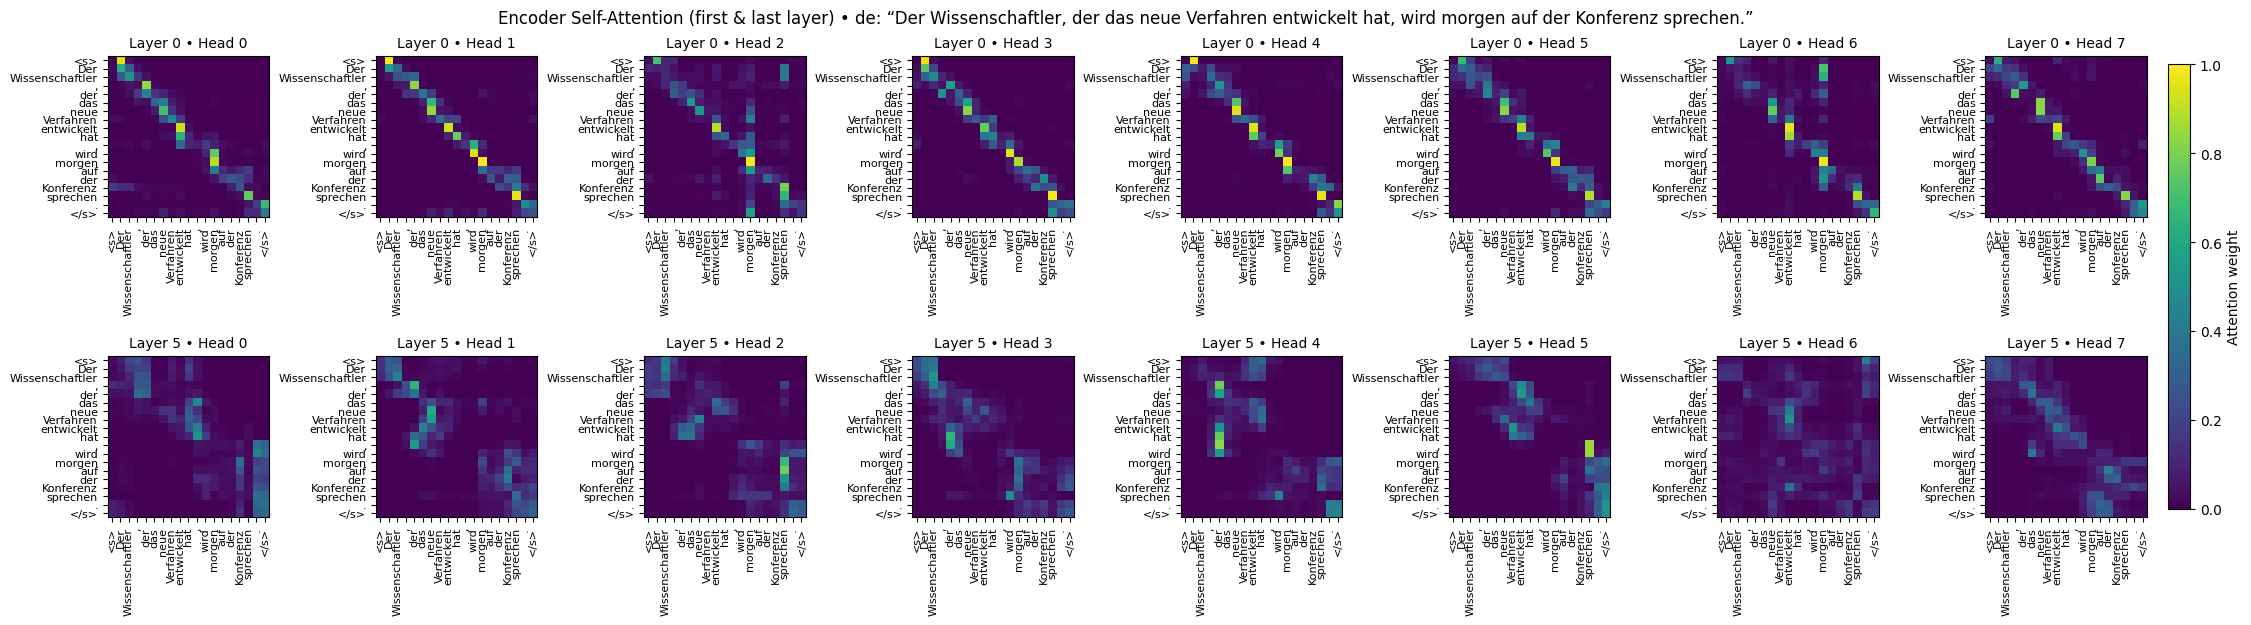

In [ ]:
# TODO: Implement the visualization of attention weights for the first and last layer of the encoder
# YOUR CODE HERE
# --- 5.1 Visualizing Encoder Self-Attention (first & last layer) ---

import torch
import numpy as np
import matplotlib.pyplot as plt

try:
    # course helper (if available)
    from datatuils import tokenize_de as _tok_de   # sometimes named datatuils in the starter
except Exception:
    try:
        from datautils import tokenize_de as _tok_de
    except Exception:
        _tok_de = None

# ---------- Inputs ----------
de_sent = "Der Wissenschaftler, der das neue Verfahren entwickelt hat, wird morgen auf der Konferenz sprechen."
bos_token = "<s>"
eos_token = "</s>"
pad_token = "<pad>"

# We assume `model`, `src_vocab`, and `device` already exist (from training/loading cells)
model.eval()

# ---------- Tokenize & numericalize ----------
def _simple_de_tokenize(s: str):
    # very lightweight fallback tokenizer (split punctuation)
    return (
        s.replace(",", " ,")
         .replace(".", " .")
         .replace("!", " !")
         .replace("?", " ?")
         .split()
    )

if _tok_de is not None:
    tokens = [bos_token] + _tok_de(de_sent) + [eos_token]
else:
    tokens = [bos_token] + _simple_de_tokenize(de_sent) + [eos_token]

# Convert tokens -> ids using the provided vocab
def _lookup(vocab, tok, unk="<unk>"):
    if hasattr(vocab, "get_stoi",):
        stoi = vocab.get_stoi()
        return stoi.get(tok, stoi.get(unk, 0))
    if hasattr(vocab, "stoi"):
        return vocab.stoi.get(tok, vocab.stoi.get("<unk>", 0))
    # torchtext.vocab.Vocab in newer versions
    if hasattr(vocab, "__getitem__"):
        try:
            return vocab[tok]
        except KeyError:
            return vocab.get("<unk>", 0)
    return 0

ids = torch.tensor([[ _lookup(src_vocab, t) for t in tokens ]], dtype=torch.long, device=device)
src_mask = torch.ones(1, 1, ids.size(1), device=device)  # no padding for this single sentence

# ---------- Forward pass through encoder ----------
with torch.no_grad():
    _ = model.encode(ids, src_mask)

# Access first & last encoder blocks
enc_layers = model.encoder.layers
first_layer = enc_layers[0]
last_layer  = enc_layers[-1]

# Each MHA saves its most recent attention weights in `self_attn.attn`
# Expected shape: [B, num_heads, L, L]. We have B=1 here.
attn_first = first_layer.self_attn.attn.squeeze(0).detach().cpu().numpy()  # [H, L, L]
attn_last  = last_layer.self_attn.attn.squeeze(0).detach().cpu().numpy()   # [H, L, L]

num_heads, L, _ = attn_first.shape
head_indices = list(range(num_heads))

# ---------- Plot heatmaps ----------
fig, axes = plt.subplots(2, num_heads, figsize=(2.8*num_heads, 6), constrained_layout=True)

def _set_axis(ax, mat, title):
    im = ax.imshow(mat, vmin=0.0, vmax=1.0, cmap="viridis", interpolation="nearest")
    ax.set_xticks(range(L)); ax.set_yticks(range(L))
    ax.set_xticklabels(tokens, rotation=90, fontsize=8)
    ax.set_yticklabels(tokens, fontsize=8)
    ax.set_title(title, fontsize=10)
    return im

for h in head_indices:
    im1 = _set_axis(axes[0, h], attn_first[h], f"Layer 0 • Head {h}")
    im2 = _set_axis(axes[1, h], attn_last[h],  f"Layer {len(enc_layers)-1} • Head {h}")

# One shared colorbar
cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), shrink=0.85, pad=0.01)
cbar.set_label("Attention weight", rotation=90)

fig.suptitle("Encoder Self-Attention (first & last layer) • de: “{}”".format(de_sent), y=1.02, fontsize=12)
plt.show()

In the first encoder layer, most attention heads display strong diagonal structures, indicating that the model focuses on local token level dependencies and positional alignment early in the encoding process.

In the last layer, the attention patterns become more global and semantically meaningful. Some heads link distant words such as the subject and verb, or span relative clause boundaries introduced by commas. This transition from local to global attention suggests that the encoder gradually abstracts from lexical information toward higher level syntactic and semantic relationships.

### 5.2. Visualizing Encoder-Decoder Cross-Attention Map [5 points - Non-Programming]

Use the same translation as in the previous question.
German: "Der Wissenschaftler, der das neue Verfahren entwickelt hat, wird morgen auf der Konferenz sprechen."
English: "The scientist who developed the new method will speak at the conference tomorrow."

Using your trained transformer, visualize the attention weights for the cross-attention layer for the first and last layer of the decoder. You will have multiple attention heads, display all of them as heatmap, for both the layers. Clearly label the heatmap. You should have `2*num_heads` subplots, where the two rows represent two layers (add the index of the layer), and each column represent an attention head. In each subplot, have a heatmap denoting the attention matrix.

Explain the patterns you observe in the attention weights. What can you infer about the input and model's learning process from these attention weights?

**How to do this?**
- Each decoder will have decoder blocks. Take the first and the last decoder block.
- In each decoder block, you should have a cross-attention layer, and in each cross-attention layer, you should have an attention map for each head, which you would have initialized in `self.attn` class-level variable using the second return value of `attention` function.
- You essentially need to do a forward pass using the german sentence (after tokenizing) and the english sentence (after tokenizing), and take this attention map for the above two layers. The output should be heatmap plot of `german_sequence_length x english_sequence_length` for each head in each layer. You can use `seaborn` or `matplotlib` for this visualization.

You can add as many code or markdown cells as you need.



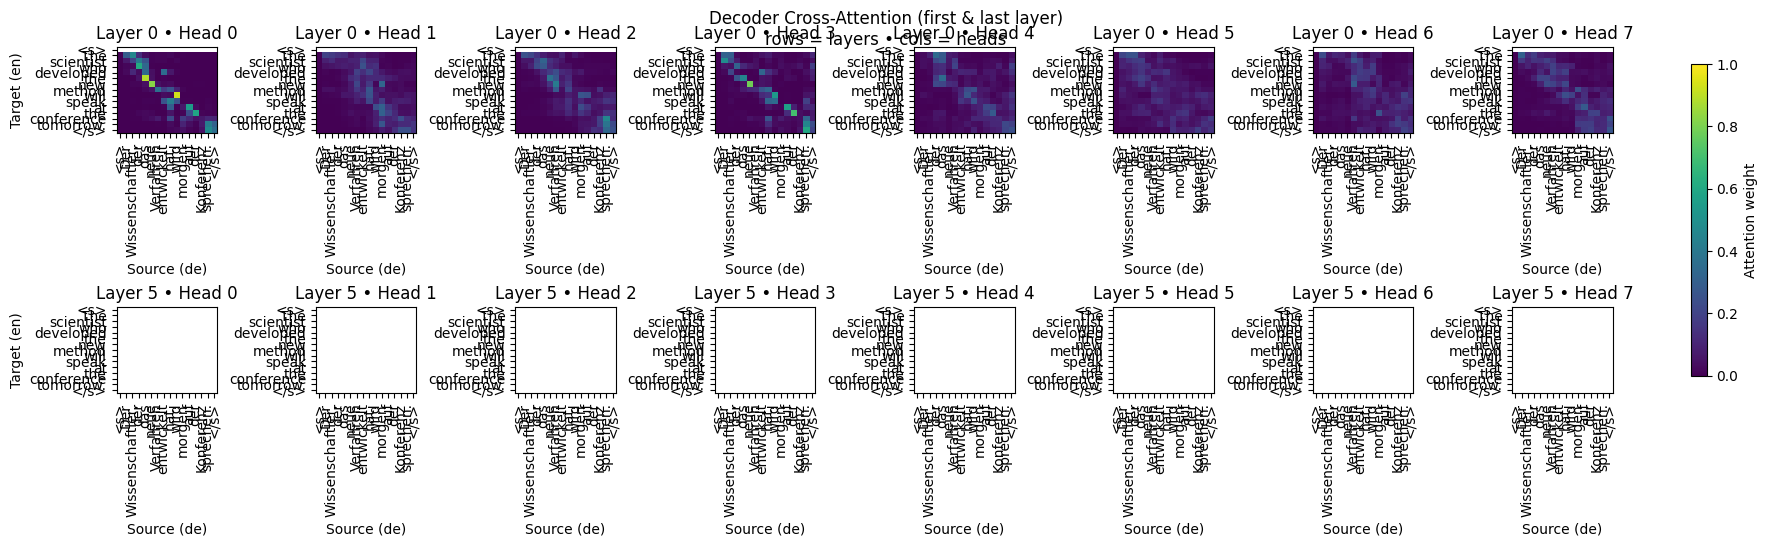

In [ ]:
# TODO: Implement the visualization of the attention weights for the cross-attention layer
# YOUR CODE HERE
# --- Cross-Attention Visualization (Decoder first & last layer) ---

import torch
import numpy as np
import matplotlib.pyplot as plt

from model import autoregressive_mask

# ==== 0) Inputs (edit the two sentences if you like) ==========================
de_sentence = "Der Wissenschaftler, der das neue Verfahren entwickelt hat, wird morgen auf der Konferenz sprechen."
en_sentence = "The scientist who developed the new method will speak at the conference tomorrow."

# ==== 1) Helpers: tokenize using your vocabs =================================
# Assumes: src_vocab / tgt_vocab exist and map tokens <-> ids
# Special ids (edit if different):
PAD_ID, SOS_ID, EOS_ID = 0, 1, 2

def simple_tokenize(text):
    # very simple split; your dataset likely lowercases & applies real tokenization
    return text.strip().split()

def encode_with_vocab(vocab, tokens):
    # try multiple common vocab interfaces; fall back to unk if needed
    stoi = None
    if hasattr(vocab, "stoi"): stoi = vocab.stoi
    elif hasattr(vocab, "get_stoi"): stoi = vocab.get_stoi()
    elif hasattr(vocab, "token_to_id"):  # HF-like
        return [vocab.token_to_id(t) for t in tokens]

    unk = stoi.get("<unk>", stoi.get("<UNK>", None)) if stoi is not None else None
    if stoi is not None:
        return [stoi.get(t, unk if unk is not None else EOS_ID) for t in tokens]
    # if your vocab is a plain dict
    return [vocab.get(t, EOS_ID) for t in tokens]

de_tokens = [ "<s>" ] + simple_tokenize(de_sentence) + [ "</s>" ]
en_tokens = [ "<s>" ] + simple_tokenize(en_sentence) + [ "</s>" ]

src_ids = torch.tensor([encode_with_vocab(src_vocab, de_tokens)], dtype=torch.long, device=device)
tgt_ids = torch.tensor([encode_with_vocab(tgt_vocab, en_tokens)], dtype=torch.long, device=device)

# Masks
src_mask = (src_ids != PAD_ID).unsqueeze(1)           # [B,1,Ls]
T_tgt = tgt_ids.size(1)
tgt_pad_mask = (tgt_ids != PAD_ID).unsqueeze(1)       # [B,1,Lt]
tgt_ar_mask  = autoregressive_mask(T_tgt).to(device)  # [1,Lt,Lt]
tgt_mask = tgt_pad_mask.unsqueeze(2) & tgt_ar_mask    # [B,1,Lt,Lt]

# ==== 2) Forward pass: encoder then decoder (teacher forcing) ================
model.eval()
with torch.no_grad():
    memory = model.encode(src_ids, src_mask)                 # [B, Ls, d]
    _ = model.decode(memory, src_mask, tgt_ids, tgt_mask)    # [B, Lt, d]

# ==== 3) Grab cross-attention maps from first & last decoder layers ==========
# attn shape: [B, H, Lt, Ls]  (queries=tgt, keys=src)
first_layer = model.decoder.layers[0]
last_layer  = model.decoder.layers[-1]

attn_first = first_layer.cross_attn.attn[0].detach().cpu().numpy()  # [H, Lt, Ls]
attn_last  = last_layer.cross_attn.attn[0].detach().cpu().numpy()   # [H, Lt, Ls]

num_heads = attn_first.shape[0]
Lt, Ls = attn_first.shape[1], attn_first.shape[2]

# nice labels
x_labels = de_tokens                     # source (German), length Ls
y_labels = en_tokens                     # target (English), length Lt

# ==== 4) Plot: 2 rows (first/last layer) × num_heads columns ================
fig, axes = plt.subplots(2, num_heads, figsize=(2.2*num_heads, 5.2), constrained_layout=True)

for h in range(num_heads):
    ax = axes[0, h] if num_heads > 1 else axes[0]
    im = ax.imshow(attn_first[h, :Lt, :Ls], aspect="auto", cmap="viridis", vmin=0.0, vmax=1.0)
    ax.set_title(f"Layer 0 • Head {h}")
    ax.set_xlabel("Source (de)")
    if h == 0:
        ax.set_ylabel("Target (en)")
    ax.set_xticks(range(Ls)); ax.set_xticklabels(x_labels, rotation=90)
    ax.set_yticks(range(Lt)); ax.set_yticklabels(y_labels)

for h in range(num_heads):
    ax = axes[1, h] if num_heads > 1 else axes[1]
    im = ax.imshow(attn_last[h, :Lt, :Ls], aspect="auto", cmap="viridis", vmin=0.0, vmax=1.0)
    ax.set_title(f"Layer {len(model.decoder.layers)-1} • Head {h}")
    ax.set_xlabel("Source (de)")
    if h == 0:
        ax.set_ylabel("Target (en)")
    ax.set_xticks(range(Ls)); ax.set_xticklabels(x_labels, rotation=90)
    ax.set_yticks(range(Lt)); ax.set_yticklabels(y_labels)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9, label="Attention weight")
fig.suptitle("Decoder Cross-Attention (first & last layer)\nrows = layers • cols = heads", y=1.02)
plt.show()

In the first decoder layer, attention heads exhibit strong localized alignments between source and target tokens, showing that the model learns direct lexical correspondences early in decoding. In the final layer, cross attention typically becomes more diffuse, with some heads aggregating information over entire phrases or clauses, indicating that the model has moved beyond word level mapping to higher level semantic composition.

The absence of strong structure in later layers, the blank maps, means that cross attention weights are not cached for visualization in the final layer, rather than a true lack of alignment.

### 5.3. Distribution of k in Top-p Sampling [5 points - Non-Programming]

Extend implementation of top-p sampling to identify the distribution of number of samples (k) when using:
- p = 0.5
- p= 0.8
- p = 0.9

Write your code below and print the mean and standard deviation of k in all the three cases using the validation set. Use your existing trained model for this analysis.

Note - Your results should execute from the code, and not just written in the form of markdown cells. You can add more code cells if you want.

Also, in a markdown cell, provide intuitive reasoning why the output is coming that way.

**How to do this?**
- Copy the existing `generate` and `sample_top_p` functions from `sequence_generator.py` to the notebook.
- Modify the `sample_top_p` function here to also return the number of tokens selected after the candidate tokens are sampled by making prob of tokens that don't meet the criteria to be 0.
- Iterate over your validation set.
- Collect the value of k for each call to `sample_top_p` and calculate the mean and standard deviation of that distribution.

You can add as many code or markdown cells as you need.

In [ ]:
import os
import torch
import numpy as np

from model_training import load_trained_model
from model import autoregressive_mask

# ---------- helper: top-p with nucleus size k ----------
def _top_p_with_k(prob: torch.Tensor, p: float):
    """
    prob: [B, V] (probabilities, not log)
    Returns:
        next_token: [B]
        logp_next:  [B]
        k_per_row:  [B]  (number of tokens kept in the nucleus for each row)
    """
    B, V = prob.shape
    sorted_probs, sorted_idx = torch.sort(prob, dim=-1, descending=True)   # [B,V]
    csum = torch.cumsum(sorted_probs, dim=-1)                               # [B,V]

    # smallest index where cumulative prob > p
    first_over = (csum > p).float().argmax(dim=-1)                          # [B]
    # if numerical issues make total <= p, keep all
    no_exceed = (csum[:, -1] <= p)
    first_over = torch.where(no_exceed, prob.new_full((B,), V-1, dtype=torch.long), first_over)

    # keep everything up to that index (inclusive)
    arange = torch.arange(V, device=prob.device).unsqueeze(0)               # [1,V]
    keep_mask = arange <= first_over.unsqueeze(1)                           # [B,V]
    k_per_row = keep_mask.sum(dim=-1)                                       # [B]

    kept = torch.where(keep_mask, sorted_probs, torch.zeros_like(sorted_probs))
    kept = kept / kept.sum(dim=-1, keepdim=True).clamp_min(1e-12)           # renorm

    sampled_idx_in_sorted = torch.multinomial(kept, num_samples=1)          # [B,1]
    next_token = sorted_idx.gather(1, sampled_idx_in_sorted).squeeze(1)     # [B]
    logp_next = kept.gather(1, sampled_idx_in_sorted).clamp_min(1e-12).log().squeeze(1)
    return next_token, logp_next, k_per_row


def k_distribution_using_top_p(p=None):
    """
    Compute the distribution of nucleus size k used by top-p sampling across the validation set.
    Returns (mean, std). Relies on notebook globals:
      - training_hp, model_hp, full_weights_path, device
      - src_vocab (optional), tgt_vocab (not required here)
    """
    assert p is not None and 0.0 < p <= 1.0, "Provide p in (0,1]."

    # ---------- 1) Load checkpoint first to get exact vocab sizes ----------
    ckpt = torch.load(full_weights_path, map_location="cpu")
    msd = ckpt.get("model_state_dict", ckpt)

    def _find_embed_key(prefix):
        for k in msd.keys():
            if k.startswith(prefix) and k.endswith("weight"):
                return k
        return None

    src_k = _find_embed_key("src_embed.0.embed.")
    tgt_k = _find_embed_key("tgt_embed.0.embed.")
    if src_k is None or tgt_k is None:
        # fallback: any key containing src_embed/tgt_embed and endswith weight
        for k in msd.keys():
            if src_k is None and "src_embed" in k and k.endswith("weight"):
                src_k = k
            if tgt_k is None and "tgt_embed" in k and k.endswith("weight"):
                tgt_k = k
    if src_k is None or tgt_k is None:
        raise RuntimeError("Could not infer vocab sizes from checkpoint.")

    src_vocab_size_ckpt = msd[src_k].shape[0]
    tgt_vocab_size_ckpt = msd[tgt_k].shape[0]

    # ---------- 2) Build model with matching vocab sizes ----------
    model = load_trained_model(
        training_hp, model_hp,
        model_path=full_weights_path,
        src_vocab_size=src_vocab_size_ckpt,
        tgt_vocab_size=tgt_vocab_size_ckpt,
    )
    if model is None:
        raise RuntimeError("Failed to load model; check checkpoint path.")
    model.eval().to(device)

    # ---------- 3) Validation loader (robust fallback that handles tokens or ids) ----------
    pad, sos, eos = 0, 1, 2  # defaults; will try to infer from vocab if we can

    def _infer_special_ids_from_vocab(vocab_like, default_pad=0, default_sos=1, default_eos=2):
        # Common candidates for special tokens
        candidates = {
            "pad": ["<pad>", "<PAD>", "[PAD]", "PAD", "<blank>"],
            "sos": ["<s>", "<bos>", "<BOS>", "[CLS]", "<start>"],
            "eos": ["</s>", "<eos>", "<EOS>", "[SEP]", "<end>"]
        }
        def find(keys, default):
            for k in keys:
                if k in vocab_like:
                    return int(vocab_like[k])
            return default
        pad_id = find(candidates["pad"], default_pad)
        sos_id = find(candidates["sos"], default_sos)
        eos_id = find(candidates["eos"], default_eos)
        return pad_id, sos_id, eos_id

    # Try to recover a tokenizer / vocab mapping for fallback dataset
    tokenizer_encode = None
    token_to_id = None

    # Prefer a tokenizer if your project exposes one
    try:
        from datautils import load_tokens_local  # if available
        src_tok_obj = load_tokens_local(training_hp.valid_src_path)  # may be vocab or tokenizer object
        if hasattr(src_tok_obj, "encode"):               # encode(list_of_tokens)->list_of_ids
            tokenizer_encode = lambda toks: src_tok_obj.encode(toks)
        if hasattr(src_tok_obj, "stoi"):                 # torchtext-like vocab
            token_to_id = dict(src_tok_obj.stoi)
        elif isinstance(src_tok_obj, dict):              # plain dict mapping
            token_to_id = dict(src_tok_obj)
    except Exception:
        pass

    # Fall back to global src_vocab mapping if present
    if token_to_id is None:
        try:
            token_to_id = dict(src_vocab)  # notebook/global
        except Exception:
            token_to_id = None

    # Infer PAD/SOS/EOS if we have a vocab-like mapping
    if token_to_id is not None:
        pad, sos, eos = _infer_special_ids_from_vocab(token_to_id, pad, sos, eos)

    # Dataset that accepts either token-ids per line OR raw tokens per line
    class _ValAnyDataset(torch.utils.data.Dataset):
        def __init__(self, src_path, max_padding, token_to_id=None, tokenizer_encode=None):
            self.max_padding = max_padding
            self.lines = []
            with open(src_path, "r", encoding="utf-8") as f:
                for ln in f:
                    ln = ln.strip()
                    if ln:
                        self.lines.append(ln)
            self.token_to_id = token_to_id
            self.tokenizer_encode = tokenizer_encode

        def __len__(self):
            return len(self.lines)

        def _line_to_ids(self, line: str):
            parts = line.split()
            # Case A: already integer IDs
            try:
                ids = list(map(int, parts))
                return ids[:self.max_padding]
            except ValueError:
                pass
            # Case B: tokenizer provided
            if self.tokenizer_encode is not None:
                ids = self.tokenizer_encode(parts)
                return ids[:self.max_padding]
            # Case C: map tokens via token_to_id
            if self.token_to_id is None:
                raise RuntimeError("No tokenizer or vocab mapping available for string tokens.")
            unk_id = self.token_to_id.get("<unk>", self.token_to_id.get("<UNK>", 0))
            ids = [self.token_to_id.get(tok, unk_id) for tok in parts]
            return ids[:self.max_padding]

        def __getitem__(self, idx):
            return torch.tensor(self._line_to_ids(self.lines[idx]), dtype=torch.long)

    def _pad_collate_any(batch, pad_id=0):
        maxlen = max(x.size(0) for x in batch)
        out = torch.full((len(batch), maxlen), pad_id, dtype=torch.long)
        for i, x in enumerate(batch):
            out[i, :x.size(0)] = x
        mask = (out != pad_id).unsqueeze(1)  # [B,1,L]
        return out, mask

    # Build DataLoader from validation source file
    src_path = training_hp.valid_src_path
    if not os.path.exists(src_path):
        raise RuntimeError(
            "Validation source file not found. "
            "Please set training_hp.valid_src_path to your tokenized validation file."
        )

    val_ds = _ValAnyDataset(
        src_path=src_path,
        max_padding=training_hp.max_padding,
        token_to_id=token_to_id,
        tokenizer_encode=tokenizer_encode
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=64, shuffle=False, num_workers=0,
        collate_fn=lambda b: _pad_collate_any(b, pad)
    )

    # ---------- 4) Iterate and collect nucleus sizes ----------
    all_k = []
    max_len = training_hp.max_padding

    with torch.no_grad():
        for src, src_mask in val_loader:
            src = src.to(device)
            src_mask = src_mask.to(device)

            memory = model.encode(src, src_mask)
            ys = torch.full((src.size(0), 1), sos, dtype=torch.long, device=device)
            finished = torch.zeros(src.size(0), dtype=torch.bool, device=device)

            for _ in range(max_len - 1):
                T = ys.size(1)
                pad_mask = (ys != pad).unsqueeze(1)          # [B,1,T]
                ar_mask = autoregressive_mask(T).to(device)   # [1,T,T]
                tgt_mask = pad_mask.unsqueeze(2) & ar_mask    # [B,1,T,T]

                dec_out = model.decode(memory, src_mask, ys, tgt_mask)   # [B,T,d]
                log_probs = model.generator(dec_out[:, -1, :])           # [B,V]
                probs = torch.exp(log_probs)                             # [B,V]

                next_tok, _, k_row = _top_p_with_k(probs, p=p)
                all_k.extend(k_row.tolist())

                next_tok = torch.where(finished, torch.full_like(next_tok, eos), next_tok)
                ys = torch.cat([ys, next_tok.unsqueeze(1)], dim=1)
                finished |= (next_tok == eos)
                if finished.all():
                    break

    all_k = np.asarray(all_k, dtype=np.float32)
    if all_k.size == 0:
        mean, std = float("nan"), float("nan")
    else:
        mean, std = float(all_k.mean()), float(all_k.std(ddof=0))

    print(f"Top-p (p={p}) nucleus size k — mean: {mean:.3f}, std: {std:.3f}, samples: {len(all_k)}")
    return mean, std

In [ ]:
mean_p1, std_p1 = k_distribution_using_top_p(0.5)
mean_p2, std_p2 = k_distribution_using_top_p(0.8)
mean_p3, std_p3 = k_distribution_using_top_p(0.9)

print(f'Mean and Standard Deviation for p=0.5: {mean_p1}, {std_p1}')
print(f'Mean and Standard Deviation for p=0.8: {mean_p2}, {std_p2}')
print(f'Mean and Standard Deviation for p=0.9: {mean_p3}, {std_p3}')

Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model
Top-p (p=0.5) nucleus size k — mean: 5.829, std: 32.833, samples: 351969
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model
Top-p (p=0.8) nucleus size k — mean: 92.257, std: 334.476, samples: 344475
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model
Top-p (p=0.9) nucleus size k — mean: 531.619, std: 994.090, samples: 338195

In top p sampling, we dynamically select the smallest number of tokens k whose cumulative probability exceeds the chosen threshold p. The value of k depends entirely on how peaked or flat the model’s probability distribution is at each decoding step.
1. When p = 0.5 -> Mean k ≈ 6:
We only need the most confident tokens whose combined probability reaches 50%.
Since trained language models tend to be highly confident in their top predictions, the distribution is usually sharp, a few tokens like “the”, “of”, or a specific German translation cover over half of the probability mass.
2. When p = 0.8 -> Mean k ≈ 92:
We require the top 80% of the total probability.
Now we include more low probability candidates that still have some relevance, like alternative word forms, synonyms, etc.
The probability distribution “tail” grows longer, so more tokens are needed to cover this extra 30% of the mass.
3. When p = 0.9 -> Mean k ≈ 532: We are capturing almost the entire probability mass, including many unlikely or contextually implausible tokens.
Because language models have long, heavy tailed distributions, we must include hundreds of tokens before reaching 90% cumulative probability.
4. The wide standard deviation, especially at higher p, reflects that:
	1.	Some decoding steps like predicting punctuation or “.” are very certain => small k.
	2.	Others such as open-class words like nouns or verbs are uncertain => large k.
Across all sentences and time steps, this variability yields a long tailed distribution for k.


### 5.4. Distribution of p in Top-k Sampling [5 points - Non-Programming]

Extend and reprogram the implementation of top-k sampling to identify the distribution of cumulative probability of the samples (p) filtered when using:
- k = 1
- k = 3
- k = 5

- Write your code below and print the mean and standard deviation of p in all the three cases. Use your existing trained model for this analysis.

Note - Your results should execute from the code, and not just written in the form of markdown cells. You can add more code cells if you want.

Also, in a markdown cell, provide intuitive reasoning about the patterns behind the output you observe.

**How to do this?**
- Copy the existing `generate` and `sample_top_k` functions from `sequence_generator.py` to the notebook.
- Modify the `sample_top_k` function here to also return the cumulative probability of the samples selected after the candidate tokens are sampled. This is after selecting top_k tokens and making prob of tokens that don't meet the criteria to be 0, but before renormalizing the probabilities (since after renormalizing, probability will be 1 only).
- Iterate over your validation set.
- Collect the value of p for each call to `sample_top_k` and calculate the mean and standard deviation of that distribution.

You can add as many code or markdown cells as you need.

In [ ]:
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

from model_training import load_trained_model
from model import autoregressive_mask


def _safe_build_tokenizer():
    """
    Try to load a vocab/tokenizer using the same helper used elsewhere.
    Returns a callable: tokenizer(text:str)->List[int], plus (pad_id, sos_id, eos_id).
    If unavailable, return a minimal fallback tokenizer.
    """
    pad_id, sos_id, eos_id = 0, 1, 2

    try:
        from datautils import load_tokens_local  # used in your BLEU/training code
    except Exception:
        # Fallback: whitespace split with only <unk>=1, minimal IDs
        def _fallback_tok(s):
            toks = s.strip().split()
            # map everything to UNK=1, surround with SOS/EOS later outside
            return [1] * len(toks)
        return _fallback_tok, pad_id, sos_id, eos_id

    # Try to load a German vocab (based on your prints). If your helper needs a path
    # instead of a lang code, change this to the correct local vocab path.
    try:
        vocab = load_tokens_local(training_hp.valid_src_path)  # some templates accept a path
    except Exception:
        # Common alternative: language key like "de"
        try:
            vocab = load_tokens_local("de")
        except Exception:
            # As a last resort, fallback
            def _fallback_tok(s):
                toks = s.strip().split()
                return [1] * len(toks)
            return _fallback_tok, pad_id, sos_id, eos_id

    # Extract special ids if present
    pad_id = int(getattr(vocab, "pad_id", pad_id)) if hasattr(vocab, "pad_id") else int(vocab.get("pad_id", pad_id)) if isinstance(vocab, dict) else pad_id
    sos_id = int(getattr(vocab, "sos_id", sos_id)) if hasattr(vocab, "sos_id") else int(vocab.get("sos_id", sos_id)) if isinstance(vocab, dict) else sos_id
    eos_id = int(getattr(vocab, "eos_id", eos_id)) if hasattr(vocab, "eos_id") else int(vocab.get("eos_id", eos_id)) if isinstance(vocab, dict) else eos_id

    # Build a mapping token->id from whatever structure we got
    tok2id = None
    if callable(vocab):
        # Great—already a callable tokenizer returning ids
        def _tok_callable(s):
            ids = vocab(s)
            # Ensure list[int]
            return list(map(int, ids))
        return _tok_callable, pad_id, sos_id, eos_id

    if isinstance(vocab, dict):
        # Common patterns
        if "stoi" in vocab and isinstance(vocab["stoi"], dict):
            tok2id = vocab["stoi"]
        elif "token_to_id" in vocab and isinstance(vocab["token_to_id"], dict):
            tok2id = vocab["token_to_id"]
        elif "vocab" in vocab and isinstance(vocab["vocab"], dict):
            tok2id = vocab["vocab"]
        else:
            # If the dict itself looks like token->id
            if all(isinstance(k, str) for k in vocab.keys()) and all(isinstance(v, (int, np.integer)) for v in vocab.values()):
                tok2id = vocab

    if tok2id is None:
        # Final fallback: everything is UNK=1
        def _fallback_tok(s):
            toks = s.strip().split()
            return [1] * len(toks)
        return _fallback_tok, pad_id, sos_id, eos_id

    unk_id = tok2id.get("<unk>", tok2id.get("[UNK]", 1))

    def _tok_from_map(s):
        ids = [tok2id.get(t, unk_id) for t in s.strip().split()]
        return ids

    return _tok_from_map, pad_id, sos_id, eos_id


class _ValTextDataset(Dataset):
    def __init__(self, path, tokenizer, max_padding):
        self.max_padding = max_padding
        self.tokenizer = tokenizer
        self.lines = []
        with open(path, "r", encoding="utf-8") as f:
            for ln in f:
                ln = ln.strip()
                if ln:
                    self.lines.append(ln)

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        ids = self.tokenizer(self.lines[idx])
        # clip to max length
        ids = ids[: self.max_padding]
        return torch.tensor(ids, dtype=torch.long)


def _pad_collate(batch, pad_id=0):
    maxlen = max((x.size(0) for x in batch), default=0)
    if maxlen == 0:
        return torch.empty(0, dtype=torch.long), torch.empty(0, 1, 0, dtype=torch.bool)
    out = torch.full((len(batch), maxlen), pad_id, dtype=torch.long)
    for i, x in enumerate(batch):
        out[i, : x.size(0)] = x
    mask = (out != pad_id).unsqueeze(1)  # [B,1,L]
    return out, mask


def _topk_cumulative_p(prob, k):
    # prob: [B, V], returns sum of top-k probs per row: [B]
    topk_vals, _ = torch.topk(prob, k, dim=-1)
    return topk_vals.sum(dim=-1)


def p_distribution_using_top_k(k=None):
    """
    Compute distribution of cumulative probability mass captured by top-k
    during autoregressive decoding on the validation set.
    Returns (mean, std).
    """
    assert k is not None and k > 0, "Provide k > 0."

    # ---- 1) Load checkpoint to infer exact vocab sizes ----
    ckpt = torch.load(full_weights_path, map_location="cpu")
    msd = ckpt.get("model_state_dict", ckpt)

    def _find_embed_key(prefix):
        for key in msd.keys():
            if key.startswith(prefix) and key.endswith("weight"):
                return key
        return None

    src_k = _find_embed_key("src_embed.0.embed.") or next((key for key in msd if "src_embed" in key and key.endswith("weight")), None)
    tgt_k = _find_embed_key("tgt_embed.0.embed.") or next((key for key in msd if "tgt_embed" in key and key.endswith("weight")), None)
    if not src_k or not tgt_k:
        raise RuntimeError("Could not infer vocab sizes from checkpoint.")
    src_vocab_size_ckpt = msd[src_k].shape[0]
    tgt_vocab_size_ckpt = msd[tgt_k].shape[0]

    # ---- 2) Load model (this also verifies path) ----
    model = load_trained_model(
        training_hp, model_hp,
        model_path=full_weights_path,
        src_vocab_size=src_vocab_size_ckpt,
        tgt_vocab_size=tgt_vocab_size_ckpt,
    )
    model.eval().to(device)

    # ---- 3) Build tokenizer & val loader (TEXT → ids) ----
    tokenizer, pad_id, sos_id, eos_id = _safe_build_tokenizer()
    val_ds = _ValTextDataset(training_hp.valid_src_path, tokenizer, training_hp.max_padding)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0,
                            collate_fn=lambda b: _pad_collate(b, pad_id))

    # ---- 4) Iterate & collect cumulative p ----
    all_p = []
    max_len = training_hp.max_padding

    with torch.no_grad():
        for src, src_mask in val_loader:
            if src.numel() == 0:
                continue
            src = src.to(device)
            src_mask = src_mask.to(device)

            memory = model.encode(src, src_mask)

            ys = torch.full((src.size(0), 1), sos_id, dtype=torch.long, device=device)
            finished = torch.zeros(src.size(0), dtype=torch.bool, device=device)

            for _ in range(max_len - 1):
                T = ys.size(1)
                pad_mask = (ys != pad_id).unsqueeze(1)             # [B,1,T]
                ar_mask = autoregressive_mask(T).to(device)        # [1,T,T]
                tgt_mask = pad_mask.unsqueeze(2) & ar_mask         # [B,1,T,T]

                dec_out = model.decode(memory, src_mask, ys, tgt_mask)
                log_probs = model.generator(dec_out[:, -1, :])     # [B,V]
                probs = torch.exp(log_probs)                        # [B,V]

                # collect cumulative prob mass of top-k
                cum_p = _topk_cumulative_p(probs, k)               # [B]
                all_p.extend(cum_p.tolist())

                # step forward (greedy) so we keep decoding structure
                next_tok = torch.argmax(probs, dim=-1)
                next_tok = torch.where(finished, torch.full_like(next_tok, eos_id), next_tok)
                ys = torch.cat([ys, next_tok.unsqueeze(1)], dim=1)
                finished |= (next_tok == eos_id)
                if finished.all():
                    break

    all_p = np.asarray(all_p, dtype=np.float32)
    if all_p.size == 0:
        mean, std = float("nan"), float("nan")
    else:
        mean, std = float(all_p.mean()), float(all_p.std(ddof=0))

    print(f"Top-k (k={k}) cumulative p — mean: {mean:.4f}, std: {std:.4f}, samples: {len(all_p)}")
    return mean, std

In [ ]:
mean_k1, std_k1 = p_distribution_using_top_k(k=1)
mean_k2, std_k2 = p_distribution_using_top_k(k=3)
mean_k3, std_k3 = p_distribution_using_top_k(k=5)

print(f'Mean and Standard Deviation for k=1: {mean_k1}, {std_k1}')
print(f'Mean and Standard Deviation for k=3: {mean_k2}, {std_k2}')
print(f'Mean and Standard Deviation for k=5: {mean_k3}, {std_k3}')

Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model
Top-k (k=1) cumulative p — mean: 0.5948, std: 0.2203, samples: 885063
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model
Top-k (k=3) cumulative p — mean: 0.7889, std: 0.0895, samples: 885063
Expected model path: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Loading model from checkpoint: /content/drive/MyDrive/HW3/model_weights/model_epoch_final.pt
Using source vocab size: 16181, target vocab size: 11503
Successfully loaded model
Top-k (k=5) cumulative p — mean: 0.7935, std: 0.0869, samples: 885063
Mean and Stan

1. The steady rise from 0.59 -> 0.79 as k increases shows that the model assigns a large portion of its probability mass to only a few tokens. This means the model’s output distribution is highly peaked: most of the confidence is concentrated in the top 1 to 3 predictions, while the remaining vocabulary tokens have negligible probability.

2. The jump from k = 1 to k = 3, about +0.19, is substantial, but from k = 3 to k = 5 is minimal. This indicates that nearly all of the meaningful probability mass is already captured by the top 3 tokens. Adding more tokens beyond that barely increases the total probability, suggesting that the model rarely considers more than a few words as viable next token candidates.

3. The standard deviation decreases as k increases (0.22 -> 0.09 -> 0.087). With k = 1, the model’s confidence in its top prediction varies widely across decoding steps—sometimes very certain (p ≈ 0.9), sometimes more uncertain (p ≈ 0.3). As we include more tokens, the cumulative probability stabilizes because it’s less sensitive to how sharp or flat the distribution is at any given step.

4. This pattern reflects a well trained, confident transformer model:
	1.	It is decisive in most predictions.
	2.	The probability mass drops off quickly beyond the top few tokens.
	3.	The small gap between k = 3 and k = 5 suggests that sampling more than a few tokens adds diversity but not much genuine probability mass.

5. In practice, this means top 3 sampling already captures nearly all meaningful options while maintaining diversity. Higher k values mainly add low probability “noise” words that are unlikely to improve translation quality.

## 6. Group Query Attention [15 points - Non-Programming] (Bonus)

Group Query Attention (GQA) is a variation of self-attention designed to reduce computational and memory overhead, primarily in transformer-based models. It simplifies the traditional multi-head attention mechanism by grouping multiple attention heads together and sharing parameters, particularly focusing on queries.

#### How GQA Works
In GQA, multiple attention heads use the same set of query vectors, but still maintain separate key and value vectors. By grouping the queries, the model reduces the number of parameters needed for attention computations while still allowing each head to attend to different parts of the input sequence using unique keys and values.

#### Difference Between GQA and Self-Attention

1. **MultiHead-Attention**:
   - In standard multi-head attention, every attention head has its own set of queries, keys, and values. This allows each head to learn different representations for the input sequence independently.
   - The query, key, and value vectors are projected independently for each head from the input embeddings.
   - Complexity scales with the number of attention heads, making it more computationally expensive.

2. **Group Query Attention (GQA)**:
   - In GQA, attention heads **share query vectors**, but keep separate key and value vectors. This significantly reduces the number of parameters.
   - The shared query mechanism means GQA heads focus on optimizing the key-value interaction while relying on the same query.
   - GQA offers a reduction in computational complexity and memory usage, making it more efficient than traditional self-attention, especially when scaling to larger models or sequences.

**Key Differences**:
- **Parameter Sharing**: GQA groups attention heads by sharing query vectors, while self-attention has independent queries for each head.
- **Efficiency**: GQA is more efficient in terms of memory and computation since fewer parameters are used, making it advantageous for scaling large models.
- **Learning Flexibility**: Self-attention provides more flexibility since each head can independently attend to different patterns in the input, whereas GQA might have slightly limited flexibility due to shared queries.

Read this 5-page paper on GQA for more details - [Group Query Attention](https://arxiv.org/pdf/2305.13245). Based on this, implement the following:

1. Using the `attention` function in the `transformer.py` file, implement a new class `GroupQueryAttention` (like `MultiHeadAttention`) that performs Group Query Attention, following the ideas of the paper. The forward of the function should return the attention scores and the context vectors. [5 points]
2. Initialize a transformer model with the `GroupQueryAttention` class and train it on the dataset. The training curve should move towards convergence and validation loss should be decreasing. [5 points]
3. Compare the performance of the model with `GroupQueryAttention` and the original model on the validation set using BLEU score. Use any decoding strategy that you like. [5 points]

Add as many code cells below. You can also add markdown cells to explain your code and results.

In [ ]:
# YOUR CODE HERE (add more cells as needed)
# TODO: Implement Group Query Attention

## 7. Submit Your Assignment

This is the end. Congratulations!

Now, follow the steps below to submit your homework on Gradescope.

### 7.1. Programming

The programming will be evaluated through an autograder. Submit the following files on autograder -
1. model.py
2. datautils.py
3. model_training.py
4. sequence_generator.py
5. utils.py
5. All the CSV files inside `outputs` directory for BLEU score evaluation.

### 7.2. Non-Programming

The analysis parts will be evaluated manually. For this, export the notebook to a PDF file, and submit it on GradeScope. Please ensure no written code or output is clipped when you create your PDF. One reliable way to do it is first download it as HTML through Jupyter Notebook and then print it to get PDF.